# FMCG Data Analytics

## Import Dependencies

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb

## Download the Dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("beatafaron/fmcg-daily-sales-data-to-2022-2024")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hisma\.cache\kagglehub\datasets\beatafaron\fmcg-daily-sales-data-to-2022-2024\versions\16


## Load the Dataset

In [3]:
fmcg_dataset = pd.read_csv(path + "\\FMCG_2022_2024.csv", parse_dates=["date"])

## Overview

### Original Dataset

In [4]:
fmcg_dataset.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


### Quick Overview

In [5]:
fmcg_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190757 entries, 0 to 190756
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             190757 non-null  datetime64[ns]
 1   sku              190757 non-null  object        
 2   brand            190757 non-null  object        
 3   segment          190757 non-null  object        
 4   category         190757 non-null  object        
 5   channel          190757 non-null  object        
 6   region           190757 non-null  object        
 7   pack_type        190757 non-null  object        
 8   price_unit       190757 non-null  float64       
 9   promotion_flag   190757 non-null  int64         
 10  delivery_days    190757 non-null  int64         
 11  stock_available  190757 non-null  int64         
 12  delivered_qty    190757 non-null  int64         
 13  units_sold       190757 non-null  int64         
dtypes: datetime64[ns](1)

In [6]:
fmcg_dataset.isna().sum()

date               0
sku                0
brand              0
segment            0
category           0
channel            0
region             0
pack_type          0
price_unit         0
promotion_flag     0
delivery_days      0
stock_available    0
delivered_qty      0
units_sold         0
dtype: int64

In [7]:
print(f"{fmcg_dataset["category"].nunique()} Unique Categories:")
print(fmcg_dataset["category"].unique())

print(f"\n{fmcg_dataset["brand"].nunique()} Unique Brands:")
print(fmcg_dataset["brand"].unique())

print(f"\n{fmcg_dataset["sku"].nunique()} Unique SKUs:")
print(fmcg_dataset["sku"].unique())

print(f"\n{fmcg_dataset["region"].nunique()} Regions of Poland:")
print(fmcg_dataset["region"].unique())

print(f"\n{fmcg_dataset["channel"].nunique()} Sales Channels:")
print(fmcg_dataset["channel"].unique())

5 Unique Categories:
['Milk' 'Yogurt' 'ReadyMeal' 'Juice' 'SnackBar']

14 Unique Brands:
['MiBrand1' 'MiBrand4' 'YoBrand4' 'YoBrand2' 'YoBrand1' 'YoBrand3'
 'ReBrand1' 'ReBrand4' 'MiBrand3' 'JuBrand3' 'SnBrand2' 'ReBrand2'
 'SnBrand3' 'MiBrand2']

30 Unique SKUs:
['MI-006' 'MI-026' 'YO-029' 'YO-005' 'YO-012' 'YO-014' 'YO-001' 'RE-004'
 'RE-007' 'RE-015' 'MI-023' 'JU-021' 'YO-009' 'SN-027' 'YO-003' 'MI-022'
 'YO-016' 'RE-025' 'SN-010' 'RE-017' 'SN-013' 'YO-020' 'SN-019' 'MI-002'
 'MI-011' 'YO-024' 'MI-008' 'SN-028' 'YO-018' 'SN-030']

3 Regions of Poland:
['PL-Central' 'PL-North' 'PL-South']

3 Sales Channels:
['Retail' 'Discount' 'E-commerce']


### Simple Sorting and Review

In [8]:
fmcg_dataset.sort_values(by=["date", "category", "brand", "segment", "sku", "region", "channel"])
fmcg_dataset.reset_index(drop=True, inplace=True)
fmcg_dataset.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


## Feature Engineering

### Chunking Date

In [9]:
def chunking_date(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe["year"] = dataframe["date"].dt.year
    dataframe["month"] = dataframe["date"].dt.month_name()
    dataframe["week"] = dataframe["date"].dt.isocalendar().week
    dataframe["day_of_the_month"] = dataframe["date"].dt.day
    dataframe["day_of_the_week"] = dataframe["date"].dt.day_name()

    return dataframe

In [10]:
fmcg_dataset = chunking_date(fmcg_dataset)

### Categorize Weekday-Weekend

In [11]:
def categorize_weekend(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe["is_weekend"] = fmcg_dataset["day_of_the_week"].isin(["Saturday", "Sunday"])

    return dataframe

In [12]:
fmcg_dataset = categorize_weekend(fmcg_dataset)

### Season-Month Mapping

In [13]:
def season_month_mapping(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Based on https://www.timeanddate.com/calendar/seasons.html?n=262
    season_month_pair = {
        "January": "Winter", "February": "Winter", "March": "Spring", "April": "Spring",
        "May": "Spring", "June": "Summer", "July": "Summer", "August": "Summer", 
        "September": "Autumn", "October": "Autumn", "November": "Autumn", "December": "Winter" 
    }
    
    sub_season_month_pair = {
        "January": "Mid-Winter", "February": "Late-Winter", "March": "Early-Spring", "April": "Mid-Spring",
        "May": "Late-Spring", "June": "Early-Summer", "July": "Mid-Summer", "August": "Late-Summer", 
        "September": "Early-Autumn", "October": "Mid-Autumn", "November": "Late-Autumn", "December": "Early-Winter" 
    }
    
    dataframe["season"] = dataframe["month"].map(season_month_pair)
    dataframe["sub_season"] = dataframe["month"].map(sub_season_month_pair)

    return dataframe

In [14]:
fmcg_dataset = season_month_mapping(fmcg_dataset)

### Public Holiday Mapping

In [15]:
def map_public_holiday(data, public_holidays_list: list) -> pd.DataFrame:
    return (data["month"] + " " + str(data["day_of_the_month"])) in (public_holidays_list)

In [16]:
# Source from https://www.intopoland.com/travel-tips/public-holidays.html and https://en.wikipedia.org/wiki/Public_holidays_in_Poland#cite_note-2
public_holidays = {
    "new_year": "January 1",
    "epiphany": "January 6",
    "mayday_picnic": ["May 1", "May 2", "May 3"],
    "independence_day": "November 11",
    "christmas": "December 25",
    "st_stephen_day": "December 26",
    "all_saints_day": "November 1",
    "assumption_day": "August 15"
}

public_holidays_list = []

for public_holiday in public_holidays.values():
    if isinstance(public_holiday, list):
        public_holidays_list.extend(public_holiday)
    else:
        public_holidays_list.append(public_holiday)

In [17]:
fmcg_dataset["is_public_holiday"] = fmcg_dataset[["month", "day_of_the_month"]].apply(map_public_holiday, axis=1, args=(public_holidays_list,))

### Quick Review

In [18]:
fmcg_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190757 entries, 0 to 190756
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               190757 non-null  datetime64[ns]
 1   sku                190757 non-null  object        
 2   brand              190757 non-null  object        
 3   segment            190757 non-null  object        
 4   category           190757 non-null  object        
 5   channel            190757 non-null  object        
 6   region             190757 non-null  object        
 7   pack_type          190757 non-null  object        
 8   price_unit         190757 non-null  float64       
 9   promotion_flag     190757 non-null  int64         
 10  delivery_days      190757 non-null  int64         
 11  stock_available    190757 non-null  int64         
 12  delivered_qty      190757 non-null  int64         
 13  units_sold         190757 non-null  int64   

## Exploratory Data Analysis

### Performance by Region

In [19]:
def viz_monthly_performance_by_region():
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.groupby(by=["region"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["units_sold"], ascending=False, inplace=True)
    colors = ["#0353A4", "#0353A4", "#0353A4"]

    fig, ax = plt.subplots(figsize=(20, 10))
    bar_chart = ax.barh(transaction_data["region"], transaction_data["units_sold"], color=colors)
    ax.set_xlabel("Total Units Sold", fontname="garamond", fontsize=25)
    ax.set_ylabel("Region", fontname="garamond", fontsize=25)
    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width + .5, bar.get_y() + (1 / len(bar_chart)), f"{width:,} units", ha="right", va="bottom", color="white", fontweight="bold", fontsize=25, fontname="garamond")

    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 25
    plt.tight_layout()
    plt.show()
    fig.savefig("region_performace.png")

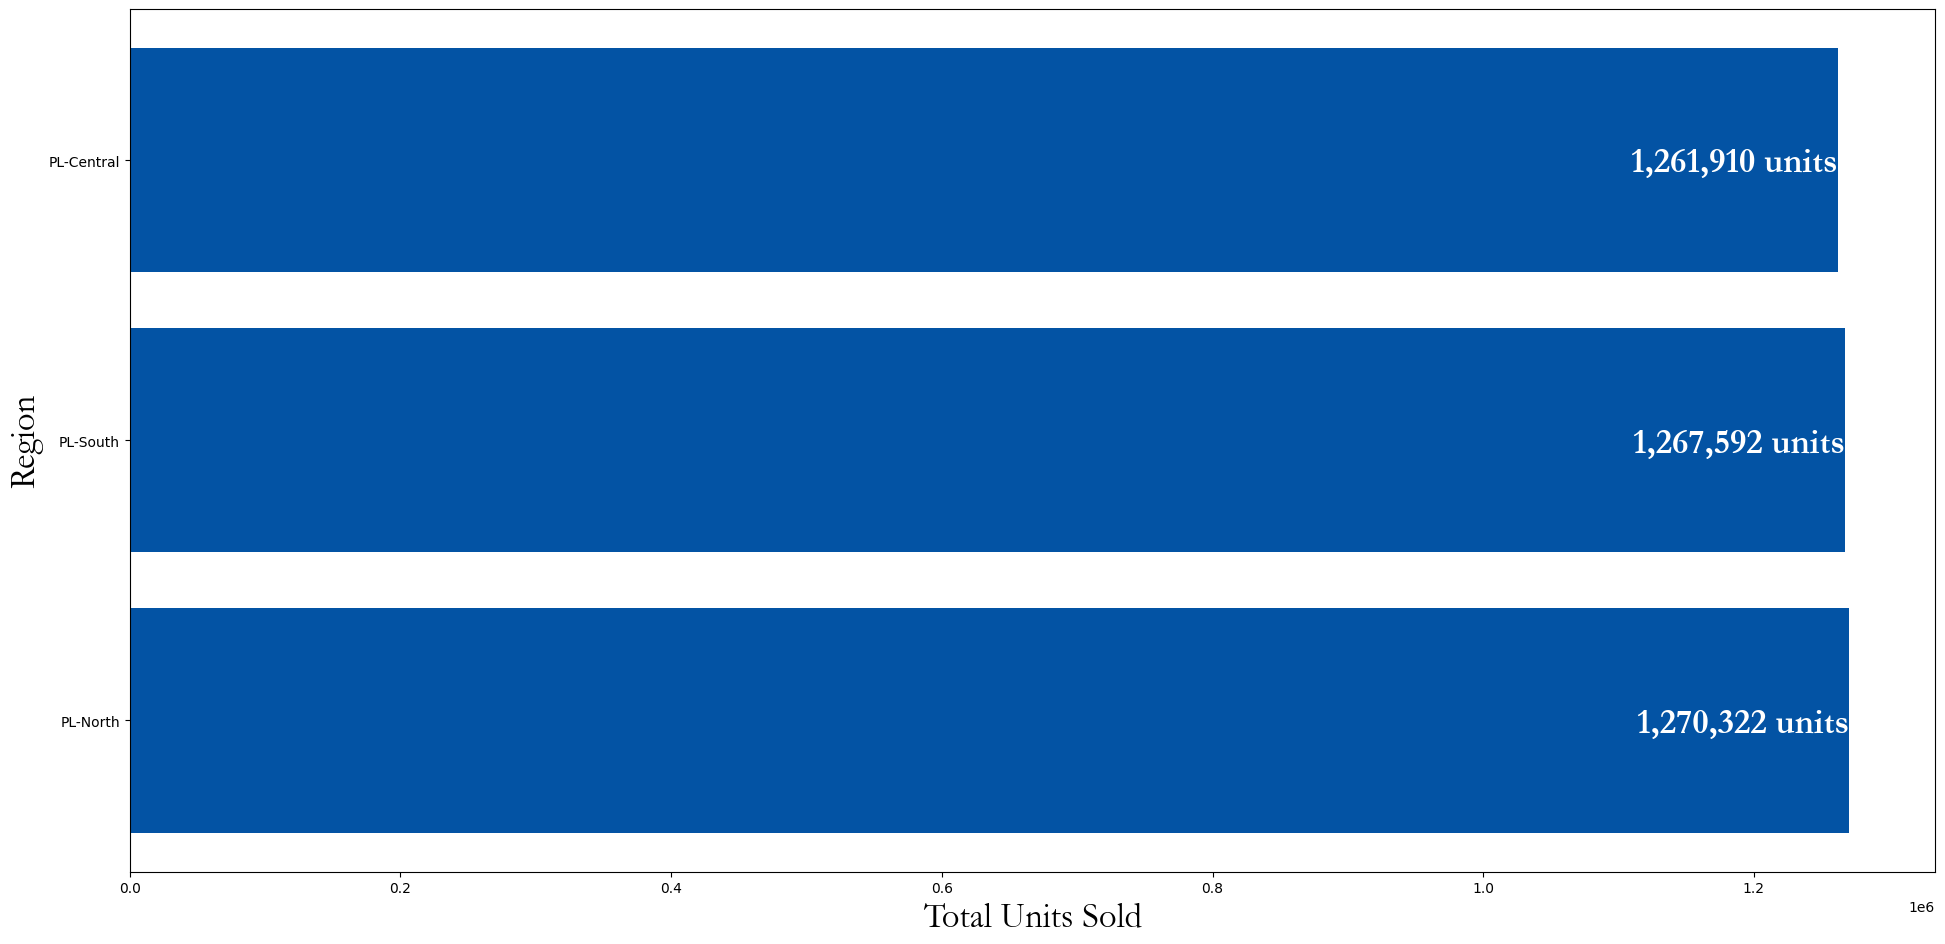

In [20]:
viz_monthly_performance_by_region()

### Performance by Category

In [21]:
def viz_monthly_performance_by_category():
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.loc[transaction_data["region"] == "PL-North"]
    transaction_data = transaction_data.groupby(by=["category"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["units_sold"], ascending=False, inplace=True)
    colors = ["#0353A4", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B"]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    bar_chart = ax.barh(transaction_data["category"], transaction_data["units_sold"], color=colors)
    ax.set_xlabel("Total Units Sold", fontname="garamond", fontsize=25)
    ax.set_ylabel("Category", fontname="garamond", fontsize=25)

    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width, bar.get_y() + (1 / len(bar_chart)), f"{width:,} units", ha="right", va="bottom", color="white", fontweight="bold", fontsize=18, fontname="garamond")

    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 25
    plt.tight_layout()
    plt.show()
    fig.savefig("category_performance.png")

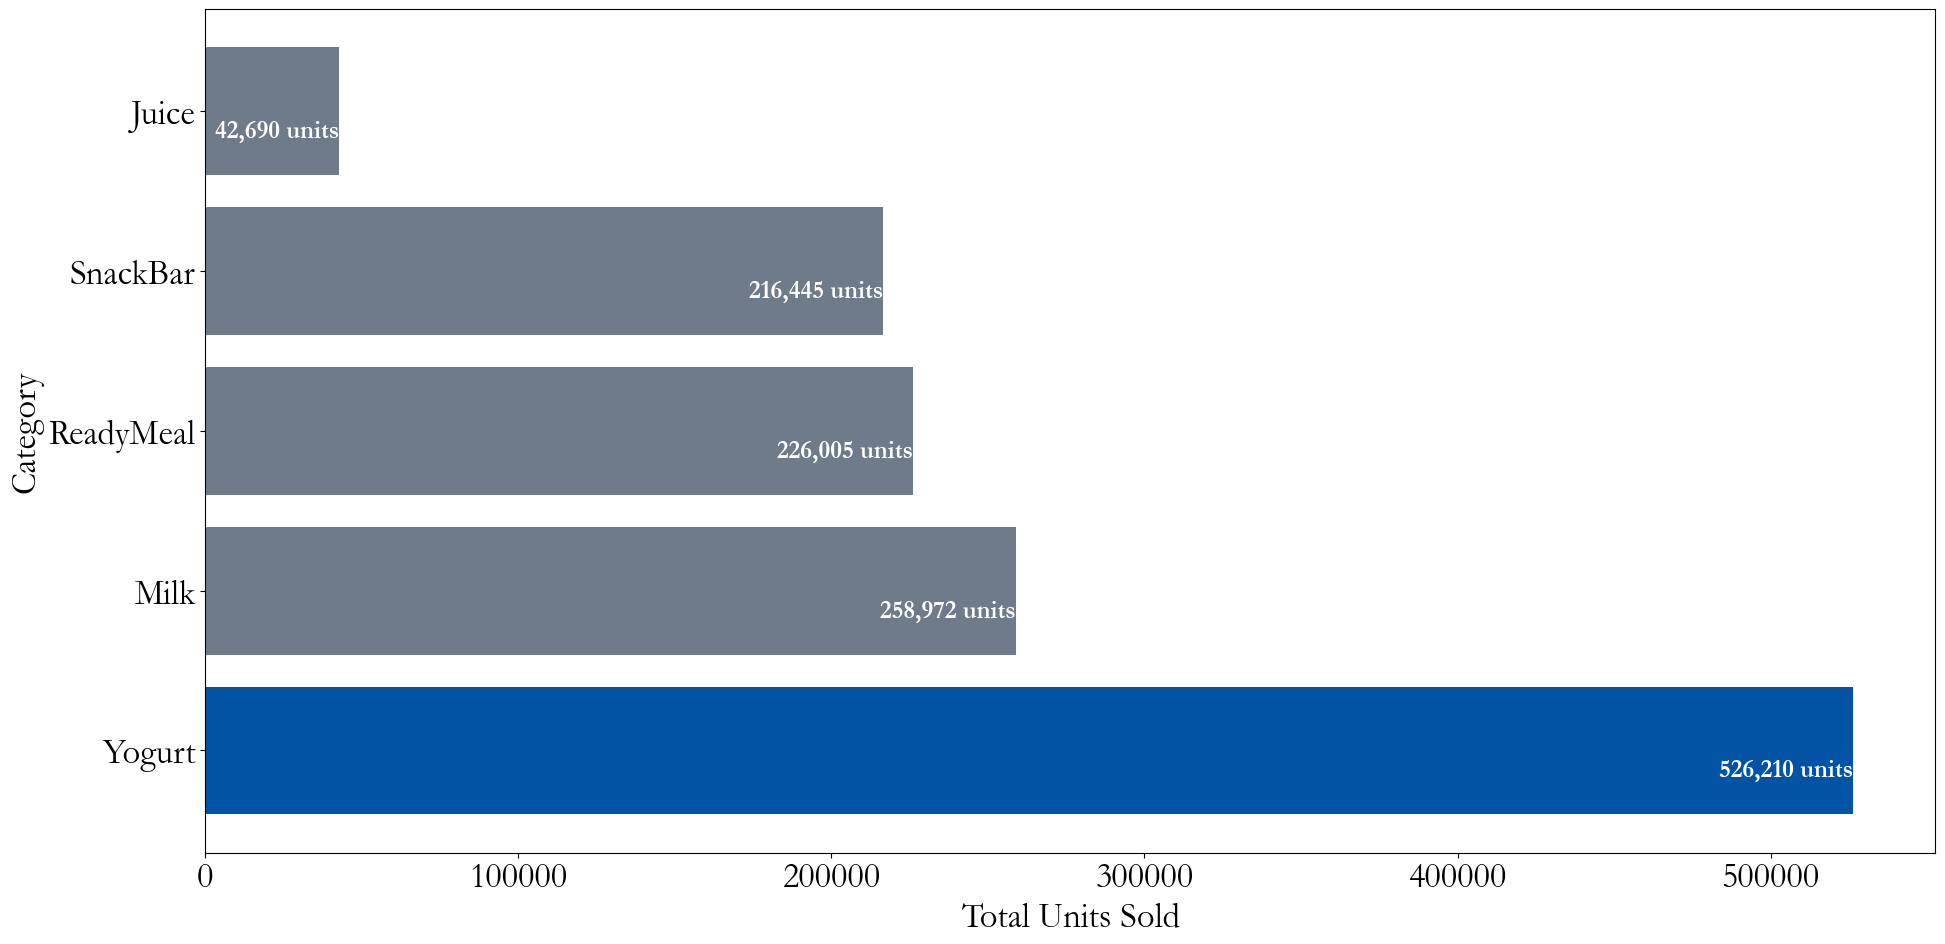

In [22]:
viz_monthly_performance_by_category()

### Performance by Brand

In [23]:
def viz_performance_by_brand(group_parameter, category_filter_parameter: str = None):
    transaction_data = fmcg_dataset.copy()

    if category_filter_parameter is not None:
        transaction_data = transaction_data.loc[transaction_data["category"] == category_filter_parameter]
    
    transaction_data = transaction_data.groupby(by=group_parameter, as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["units_sold"], ascending=False, inplace=True)
    colors = ["#0353A4", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B"]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    bar_chart = ax.barh(transaction_data[group_parameter], transaction_data["units_sold"], color=colors)
    ax.set_xlabel("Total Units Sold", fontname="garamond", fontsize=25)
    ax.set_ylabel(group_parameter.title() if len(group_parameter) > 3 else group_parameter.upper(), fontname="garamond", fontsize=25)

    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width, bar.get_y() + (1 / len(bar_chart)), f"{width:,} units", ha="right", va="bottom", color="white", fontweight="bold", fontsize=25, fontname="garamond")

    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 25
    plt.tight_layout()
    plt.show()
    fig.savefig("brand_performance.png")

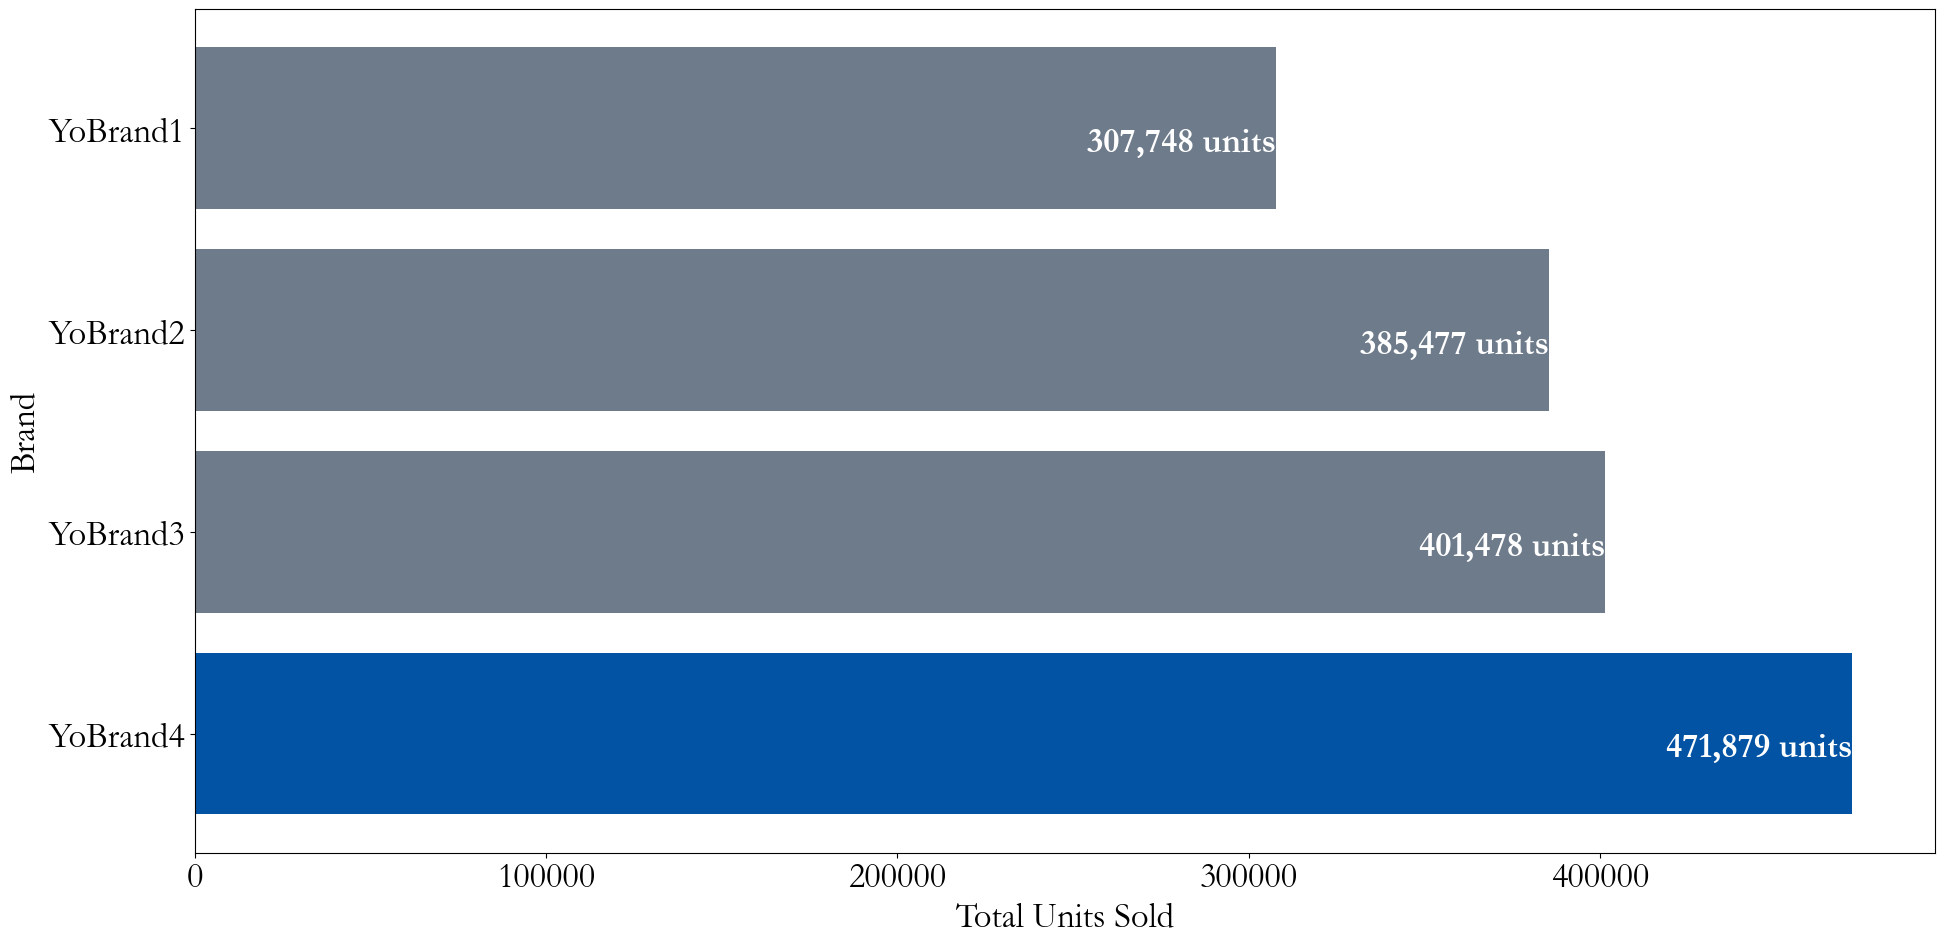

In [24]:
viz_performance_by_brand("brand", "Yogurt")

### Stockouts by Brand

In [25]:
def analyze_stockout(category: str = None, region: str = None, channel: str = None) -> pd.DataFrame:
    stock_data = fmcg_dataset.copy()
    if category is not None:
        stock_data = stock_data.loc[stock_data["category"] == category]

    if region is not None:
        stock_data = stock_data.loc[stock_data["region"] == region]

    if channel is not None:
        stock_data = stock_data.loc[stock_data["channel"] == channel]

    stock_data = stock_data.loc[stock_data["stock_available"] == 0, 
            ["date", "stock_available", "category", "brand", "sku", "channel", "season", "is_weekend", "is_public_holiday", "region"]]
        
    stock_data.reset_index(drop=True, inplace=True)
    
    return stock_data

In [26]:
def viz_stockout_by_brand():
    stockout_by_brand = analyze_stockout("Yogurt", "PL-North", "Retail").groupby(by=["brand"], as_index=False).size()
    stockout_by_brand.rename(columns={"size":"occurrences"}, inplace=True)
    stockout_by_brand.sort_values(by=["occurrences"], ascending=False, inplace=True)
    colors = ["darkred", "#6E7B8B", "#6E7B8B", "#6E7B8B"]
    fig, ax = plt.subplots(figsize= (20, 10))
    bar_chart = ax.barh(stockout_by_brand["brand"], stockout_by_brand["occurrences"], color=colors)
    ax.set_xlabel("Stockout Occurrences", fontname="garamond", fontsize=25)
    ax.set_ylabel("Brand", fontname="garamond", fontsize=25)
    
    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width, bar.get_y() + (1 / len(bar_chart)), f"{width:,} times", ha="right", va="bottom", color="white", fontweight="bold", fontsize=25, fontname="garamond")
    
    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 25
    plt.tight_layout()
    plt.show()
    fig.savefig("stockout_brand.png")

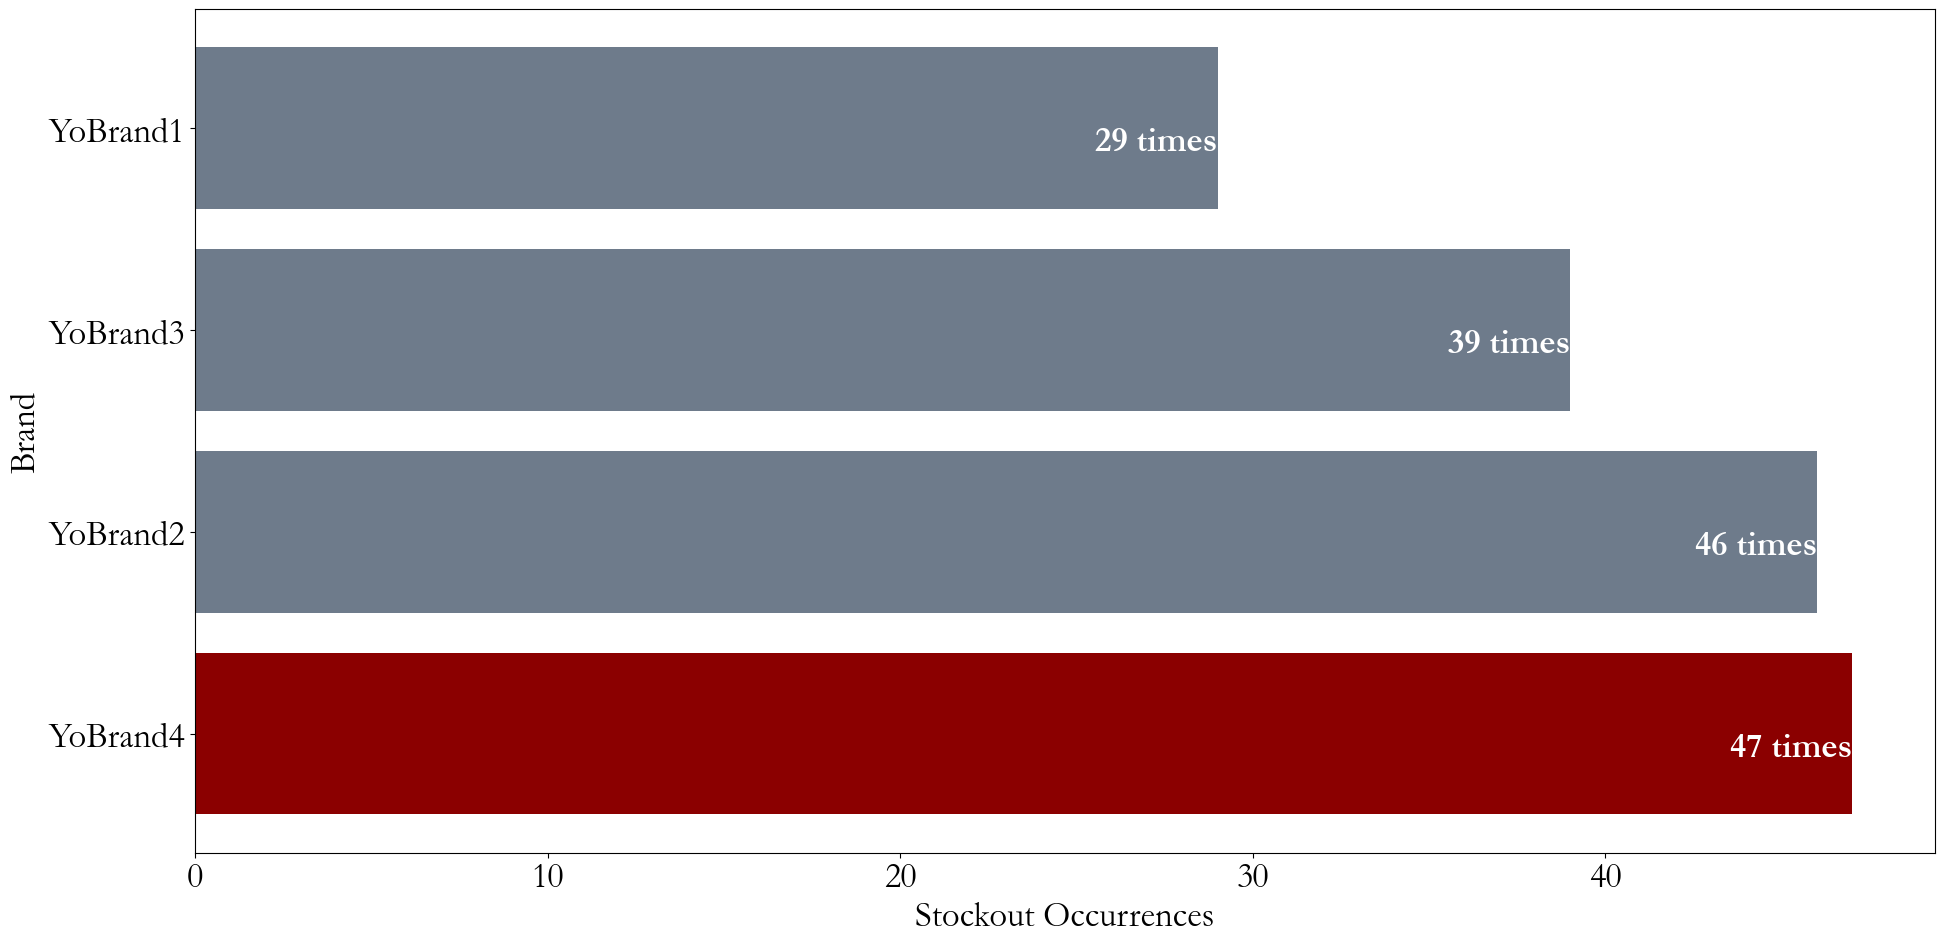

In [27]:
viz_stockout_by_brand()

### Performance by SKU

In [28]:
def viz_performance_by_sku():
    transaction_data = fmcg_dataset.copy()

    transaction_data = transaction_data.loc[(transaction_data["category"] == "Yogurt") & (transaction_data["brand"] == "YoBrand4") 
         & (transaction_data["channel"] == "Retail") & (transaction_data["region"] == "PL-North") & (transaction_data["date"] >= "2022-08-01")]
    
    transaction_data = transaction_data.groupby(by=["sku"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["units_sold"], ascending=False, inplace=True)
    colors = ["#0353A4", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B"]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    bar_chart = ax.barh(transaction_data["sku"], transaction_data["units_sold"], color=colors)
    ax.set_xlabel("Total Units Sold", fontname="garamond", fontsize=25)
    ax.set_ylabel("SKU", fontname="garamond", fontsize=25)

    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width, bar.get_y() + (1 / len(bar_chart)), f"{width:,} units", ha="right", va="bottom", color="white", fontweight="bold", fontsize=25, fontname="garamond")

    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 25
    plt.tight_layout()
    plt.show()
    fig.savefig("sku_performance.png")

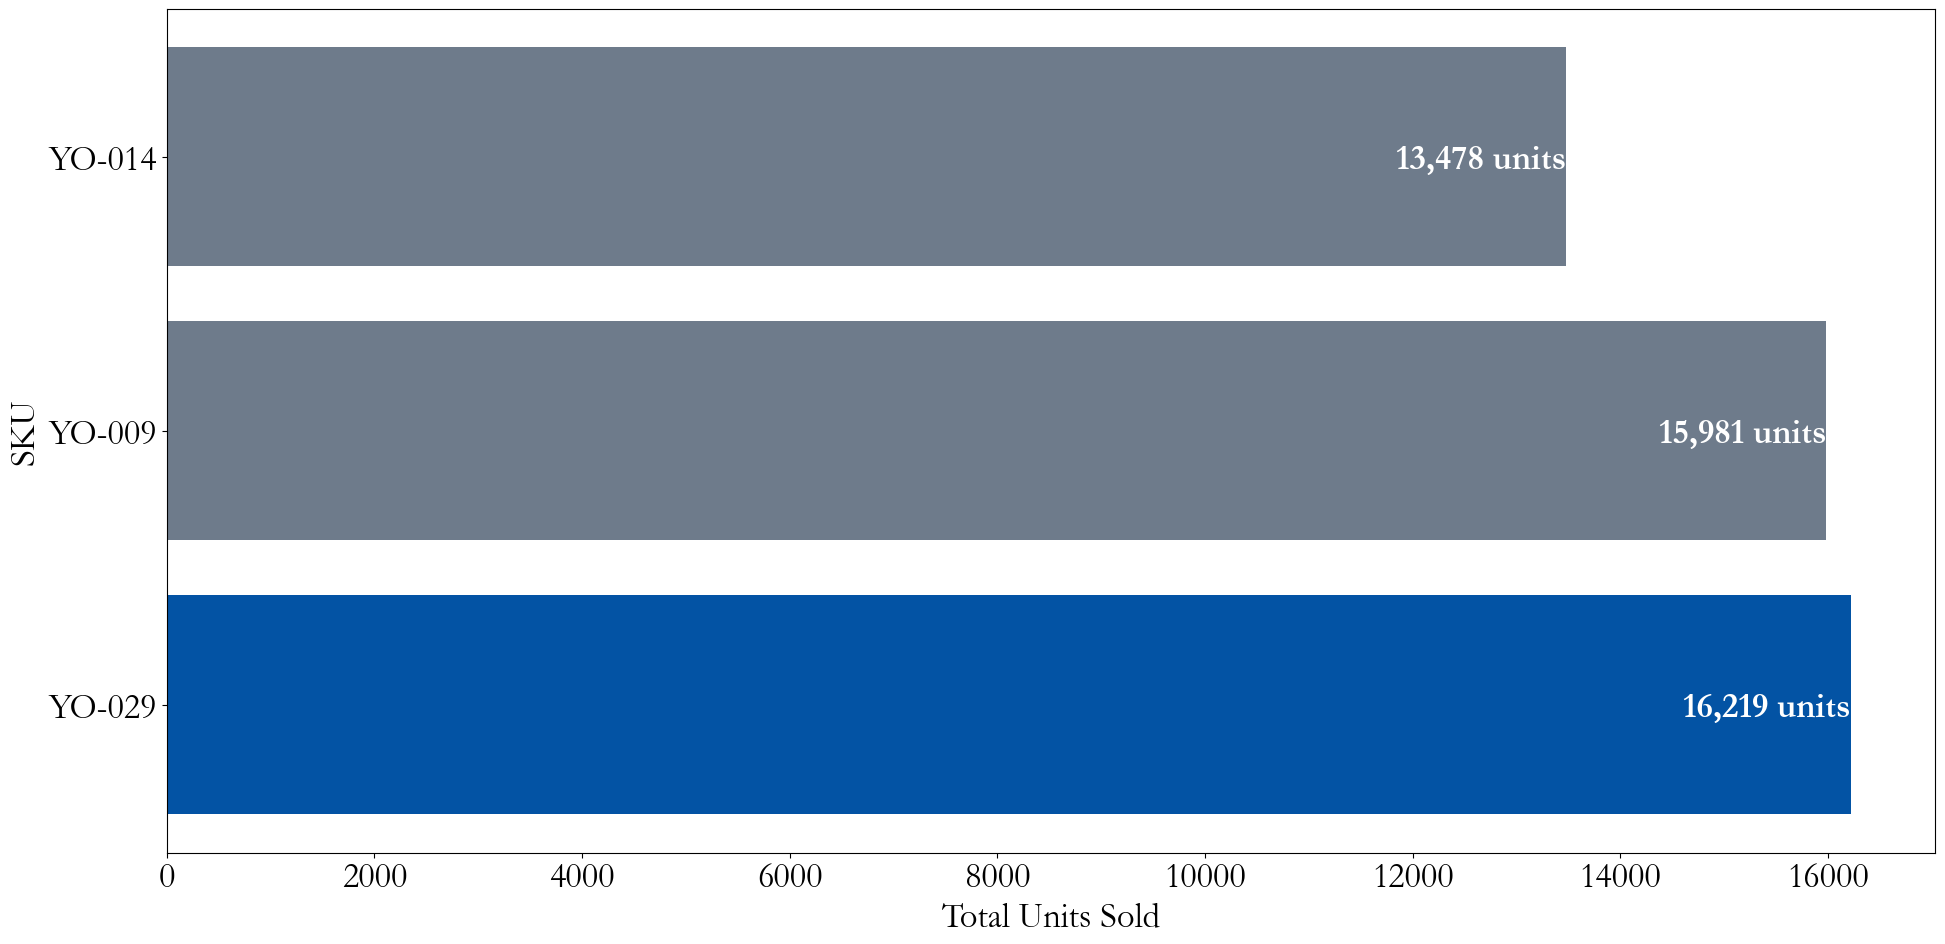

In [29]:
viz_performance_by_sku()

In [30]:
def compare_sku():
    fig, ax = plt.subplots(figsize=(25, 5))
    sku_comparison_data = fmcg_dataset.copy()
    sku_comparison_data = sku_comparison_data.loc[(sku_comparison_data["sku"].isin(("YO-009", "YO-029"))) & (sku_comparison_data["region"] == "PL-North") 
        & (sku_comparison_data["channel"] == "Retail")]
    for sku, others in sku_comparison_data.groupby(by=["sku"]):
        ax.plot(others["date"], others["units_sold"], label=sku, linewidth=.8)
    
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Units Sold", fontsize=15)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.legend(loc="upper left")
    ax.grid()
    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 15
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.show()
    fig.savefig("compare.png")

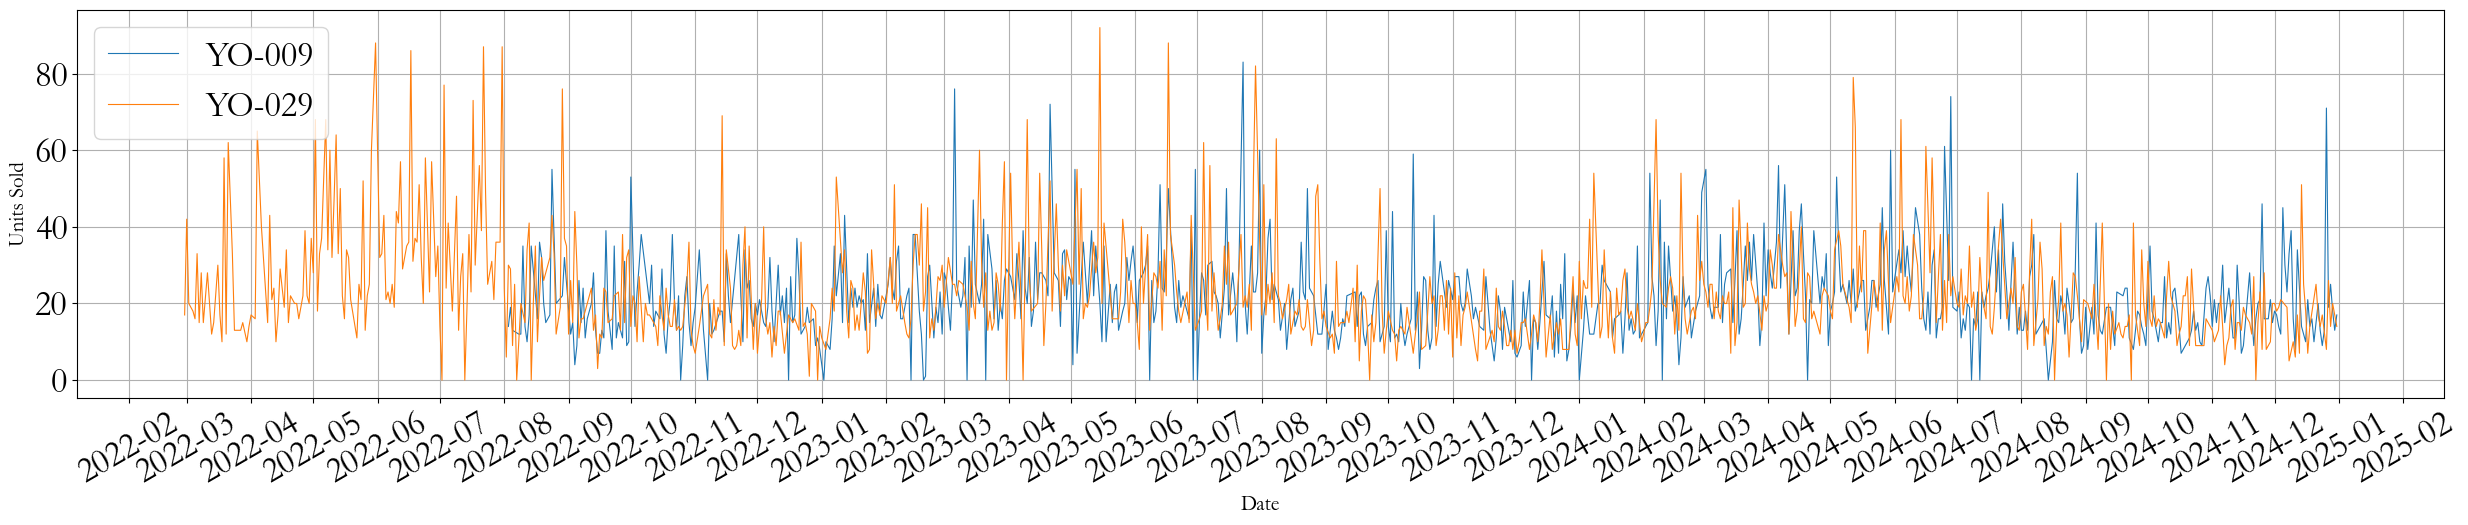

In [31]:
compare_sku()

### Stockouts by SKU

In [32]:
def viz_stockout_by_sku():
    stockout_date = fmcg_dataset.copy()
    stockout_date = stockout_date.loc[(stockout_date["brand"] == "YoBrand4") & (stockout_date["region"] == "PL-North") & (stockout_date["date"] >= "2022-08-01")
    & (stockout_date["stock_available"] == 0) & (stockout_date["channel"] == "Retail"), ["date", "year", "month", "season", "sub_season", "sku"]]
    stockout_date = stockout_date.groupby(by=["sku"], as_index=False).size()
    stockout_date.rename(columns={"size":"occurrences"}, inplace=True)
    stockout_date.sort_values(by=["occurrences"], ascending=False, inplace=True)
    colors = ["darkred", "#6E7B8B", "#6E7B8B", "#6E7B8B"]
    fig, ax = plt.subplots(figsize= (20, 10))
    bar_chart = ax.barh(stockout_date["sku"], stockout_date["occurrences"], color=colors)
    ax.set_xlabel("Stockout Occurrences", fontname="garamond", fontsize=25)
    ax.set_ylabel("SKU", fontname="garamond", fontsize=25)
    
    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width, bar.get_y() + (1 / len(bar_chart)), f"{width:,} times", ha="right", va="bottom", color="white", fontweight="bold", fontsize=25, fontname="garamond")
    
    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 25
    plt.tight_layout()
    plt.show()
    fig.savefig("stockout_sku.png")

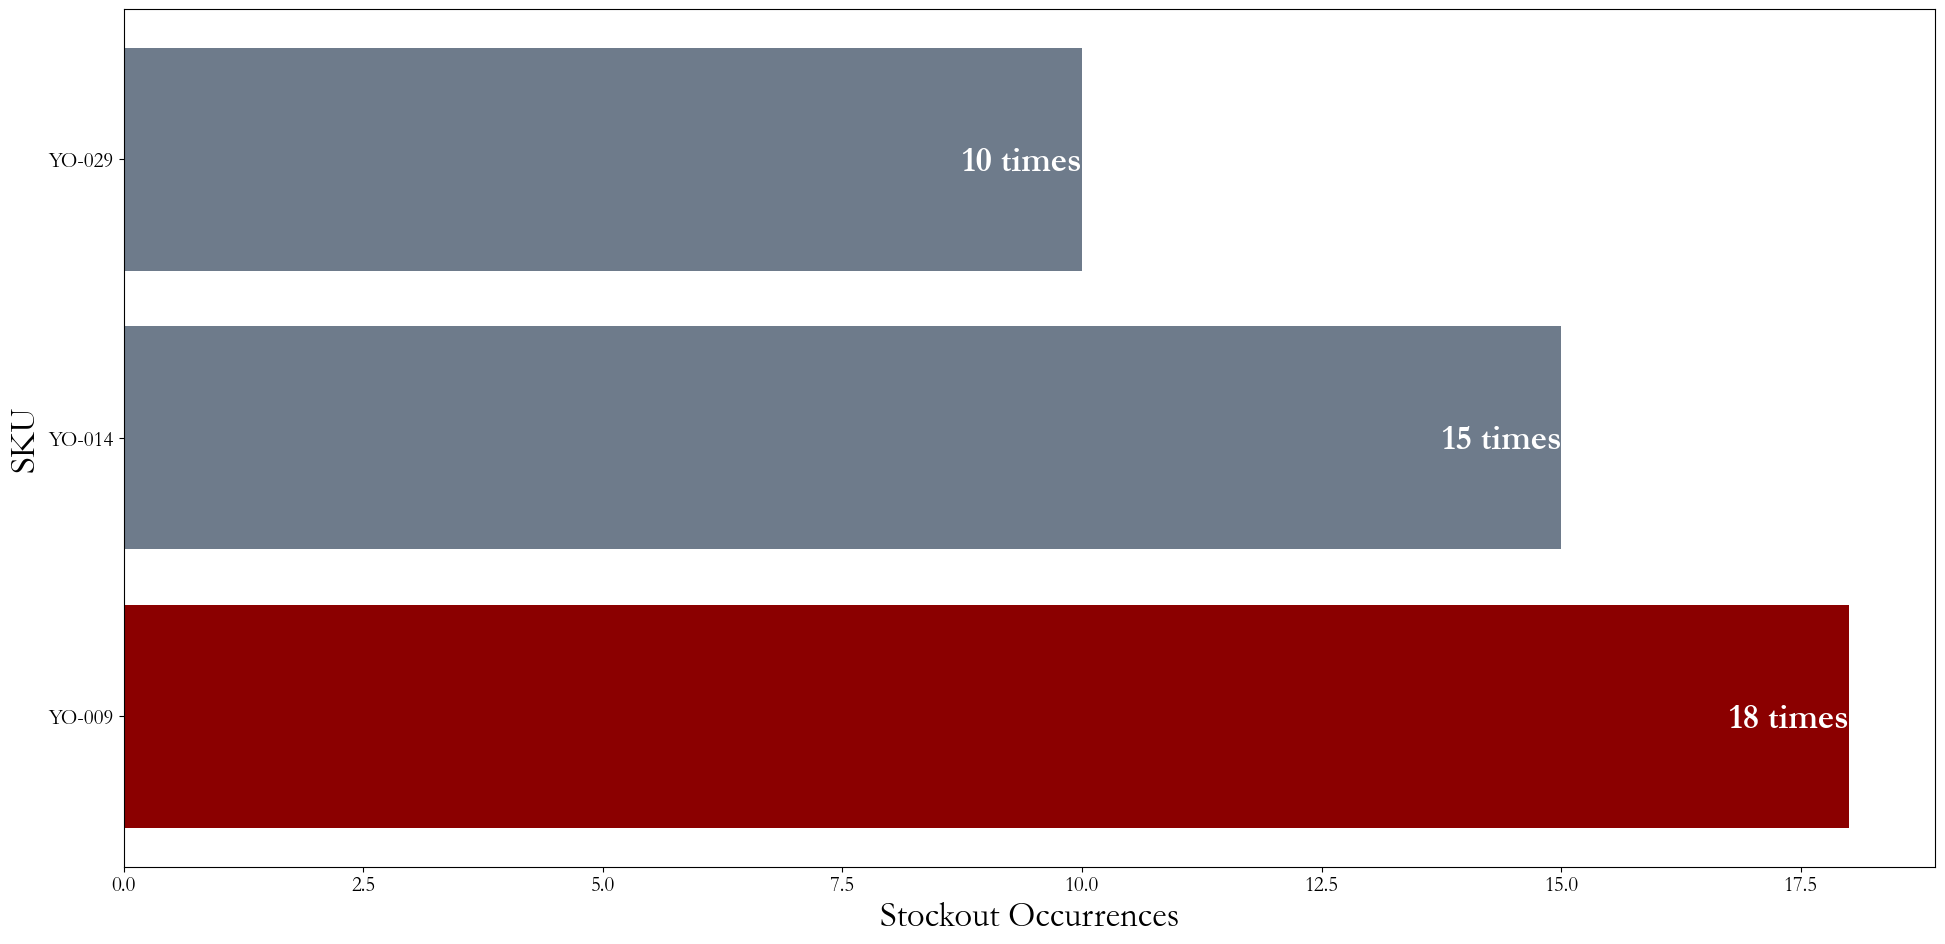

In [33]:
viz_stockout_by_sku()

In [34]:
def viz_monthly_performance_by_channel():
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.groupby(by=["channel"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["units_sold"], ascending=False, inplace=True)
    colors = ["#0353A4", "#0353A4", "#0353A4"]
    
    fig, ax = plt.subplots(figsize=(20, 5))
    bar_chart = ax.barh(transaction_data["channel"], transaction_data["units_sold"], color=colors)
    ax.set_xlabel("Total Units Sold", fontname="garamond", fontsize=15)
    ax.set_ylabel("Channel", fontname="garamond", fontsize=15)

    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width, bar.get_y() + (1 / len(bar_chart)), f"{width:,} units", ha="right", va="bottom", color="white", fontweight="bold", fontsize=15, fontname="garamond")

    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.show()

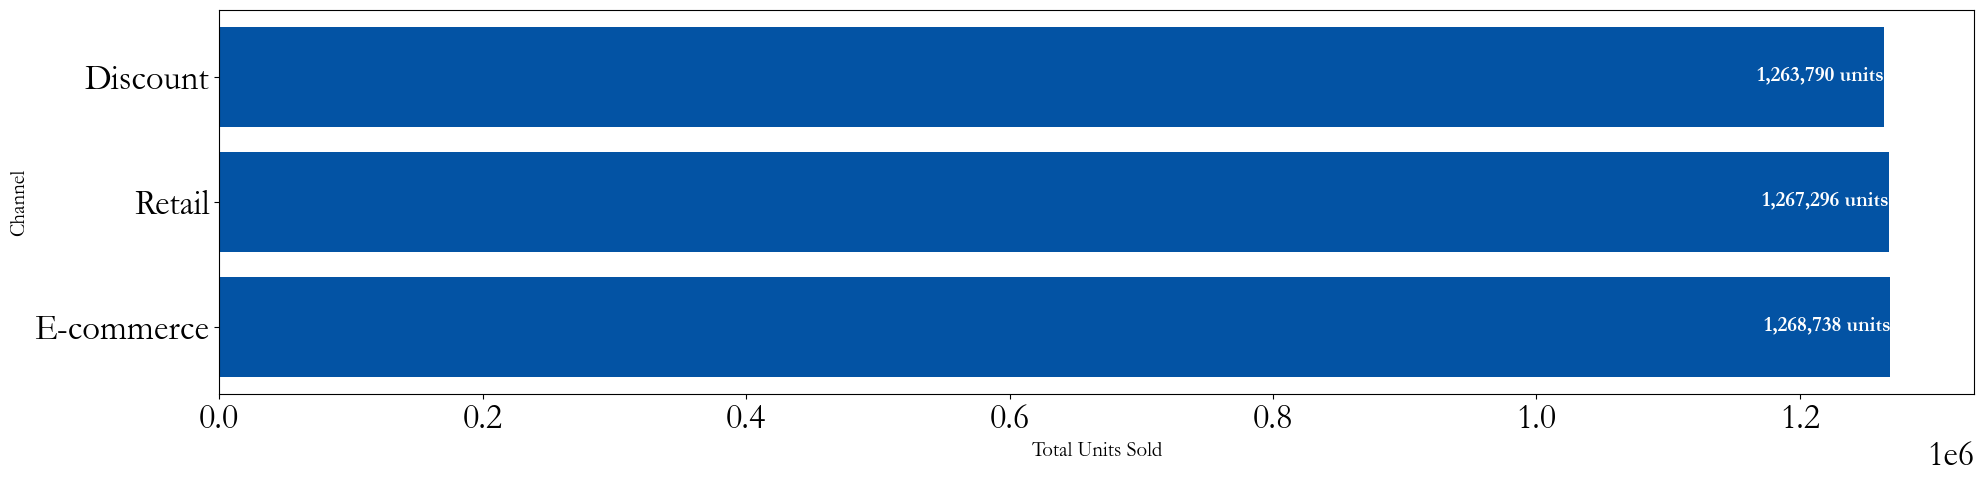

In [35]:
viz_monthly_performance_by_channel()

### Time-Series Visualization by Category

In [36]:
def time_series_viz_by_category(is_moving_average:bool = False, moving_average: int = 0):
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.loc[(transaction_data["region"] == "PL-North") & (transaction_data["channel"] == "Retail")]
    transaction_data = transaction_data.groupby(by=["date", "season", "category"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["date"], inplace=True)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    for category, others in transaction_data.groupby(by=["category"]):
        ax.plot(others["date"], others["units_sold"], label=category, linewidth=.6)
    
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Units Sold", fontsize=15)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.legend()
    ax.grid()
    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.show()
    fig.savefig("category_pattern.png")

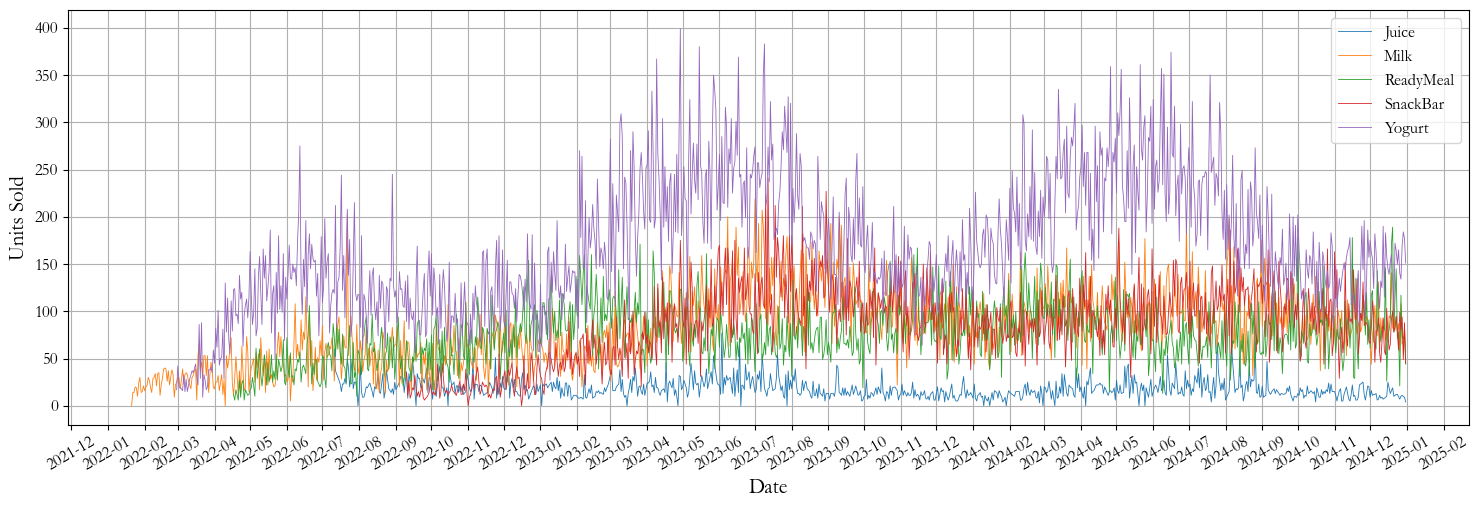

In [37]:
time_series_viz_by_category()

In [38]:
def time_series_viz_by_category(category: str, is_moving_average:bool = False, moving_average: int = 0):
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.loc[(transaction_data["category"] == category) & (transaction_data["region"] == "PL-North") & (transaction_data["channel"] == "Retail")]
    transaction_data = transaction_data.groupby(by=["date", "season"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["date"], inplace=True)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    if is_moving_average:
        ax.plot(transaction_data["date"], transaction_data["units_sold"], label=f"{category} (daily)", alpha=.2, linewidth=2)
        
        if moving_average > 0:
            transaction_data[f"moving_average_{moving_average}"] = transaction_data["units_sold"].rolling(window=moving_average).mean().round(2)
            ax.plot(transaction_data["date"], transaction_data[f"moving_average_{moving_average}"], label=f"Smoothed ({moving_average}-days MA)", linewidth=.8)
        else:
            transaction_data["moving_average_3"] = transaction_data["units_sold"].rolling(window=3).mean().round(2)
            transaction_data["moving_average_7"] = transaction_data["units_sold"].rolling(window=7).mean().round(2)
            transaction_data["moving_average_14"] = transaction_data["units_sold"].rolling(window=14).mean().round(2)
            transaction_data["moving_average_30"] = transaction_data["units_sold"].rolling(window=30).mean().round(2)
            ax.plot(transaction_data["date"], transaction_data["moving_average_3"], label="Smoothed (3-days MA)", linewidth=.8)
            ax.plot(transaction_data["date"], transaction_data["moving_average_7"], label="Smoothed (7-days MA)", linewidth=.8)
            ax.plot(transaction_data["date"], transaction_data["moving_average_14"], label="Smoothed (14-days MA)", linewidth=.8)
            ax.plot(transaction_data["date"], transaction_data["moving_average_30"], label="Smoothed (30-days MA)", linewidth=.8)
    else:
        ax.plot(transaction_data["date"], transaction_data["units_sold"], label=f"{category} (daily)", linewidth=1)

    season_colors = {"Winter":"white", "Spring":"pink", "Summer":"yellow", "Autumn":"darkorange"}
    for season_block, group_data in transaction_data.groupby((transaction_data["season"] != transaction_data["season"].shift()).cumsum()):
        start_date = group_data["date"].iloc[0]
        end_date = group_data["date"].iloc[-1]

        if (end_date - start_date).days >= 20:
            season = group_data["season"].iloc[0]
            
            ax.axvspan(start_date, end_date, color=season_colors.get(season), alpha=0.3, zorder=0)
            text_x_position = start_date + (end_date - start_date) / 2
            text_y_position = ax.get_ylim()[0] + (ax.get_ylim()[1] + ax.get_ylim()[0]) * .65
            ax.text(text_x_position, text_y_position, season, ha="center", va="center", fontweight="regular")
    
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Units Sold", fontsize=15)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.legend()
    ax.grid()
    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.show()
    fig.savefig("yogurt_pattern.png")

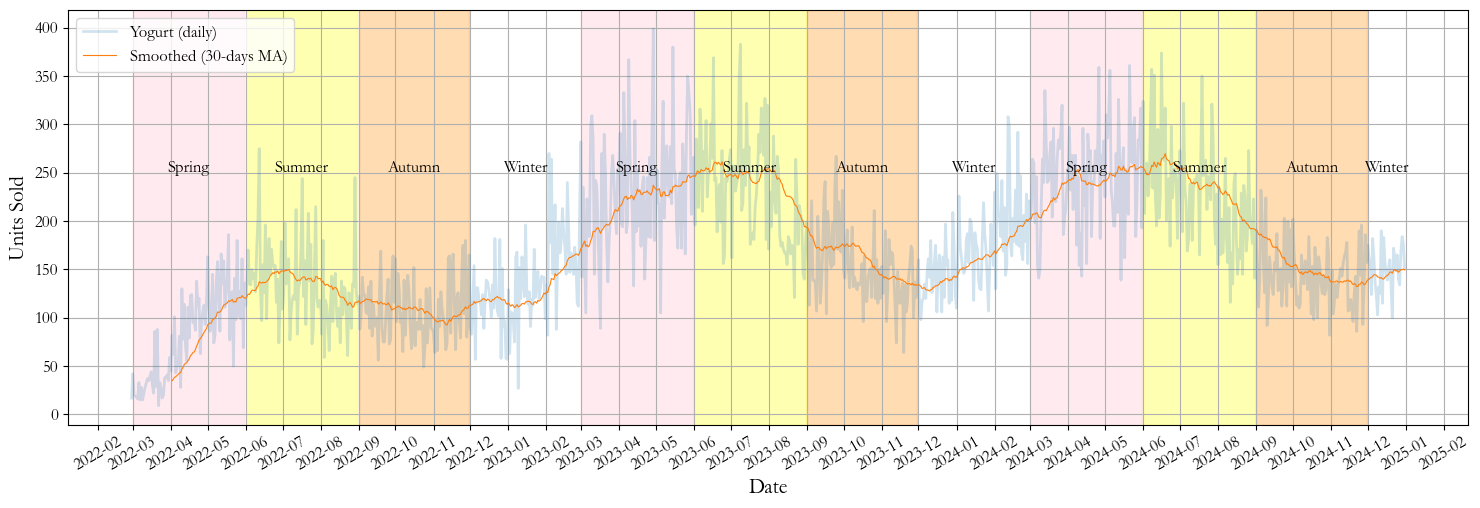

In [39]:
time_series_viz_by_category("Yogurt", True, 30)

In [40]:
def time_series_viz_by_sku(sku: str, is_moving_average:bool = False, moving_average: int = 0):
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.loc[(transaction_data["sku"] == sku) & (transaction_data["region"] == "PL-North") & (transaction_data["channel"] == "Retail")]
    transaction_data = transaction_data.groupby(by=["date", "season"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["date"], inplace=True)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    if is_moving_average:
        ax.plot(transaction_data["date"], transaction_data["units_sold"], label=f"{sku} (daily)", alpha=.2, linewidth=2)
        
        if moving_average > 0:
            transaction_data[f"moving_average_{moving_average}"] = transaction_data["units_sold"].rolling(window=moving_average).mean().round(2)
            ax.plot(transaction_data["date"], transaction_data[f"moving_average_{moving_average}"], label=f"Smoothed ({moving_average}-days MA)", linewidth=.8)
        else:
            transaction_data["moving_average_3"] = transaction_data["units_sold"].rolling(window=3).mean().round(2)
            transaction_data["moving_average_7"] = transaction_data["units_sold"].rolling(window=7).mean().round(2)
            transaction_data["moving_average_14"] = transaction_data["units_sold"].rolling(window=14).mean().round(2)
            transaction_data["moving_average_30"] = transaction_data["units_sold"].rolling(window=30).mean().round(2)
            ax.plot(transaction_data["date"], transaction_data["moving_average_3"], label="Smoothed (3-days MA)", linewidth=.8)
            ax.plot(transaction_data["date"], transaction_data["moving_average_7"], label="Smoothed (7-days MA)", linewidth=.8)
            ax.plot(transaction_data["date"], transaction_data["moving_average_14"], label="Smoothed (14-days MA)", linewidth=.8)
            ax.plot(transaction_data["date"], transaction_data["moving_average_30"], label="Smoothed (30-days MA)", linewidth=.8)
    else:
        ax.plot(transaction_data["date"], transaction_data["units_sold"], label=f"{category} (daily)", linewidth=1)

    season_colors = {"Winter":"white", "Spring":"pink", "Summer":"yellow", "Autumn":"darkorange"}
    for season_block, group_data in transaction_data.groupby((transaction_data["season"] != transaction_data["season"].shift()).cumsum()):
        start_date = group_data["date"].iloc[0]
        end_date = group_data["date"].iloc[-1]

        if (end_date - start_date).days >= 20:
            season = group_data["season"].iloc[0]
            
            ax.axvspan(start_date, end_date, color=season_colors.get(season), alpha=0.3, zorder=0)
            text_x_position = start_date + (end_date - start_date) / 2
            text_y_position = ax.get_ylim()[0] + (ax.get_ylim()[1] + ax.get_ylim()[0]) * .65
            ax.text(text_x_position, text_y_position, season, ha="center", va="center", fontweight="regular")
    
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Units Sold", fontsize=15)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.legend()
    ax.grid()
    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.show()
    fig.savefig("yogurt_pattern.png")

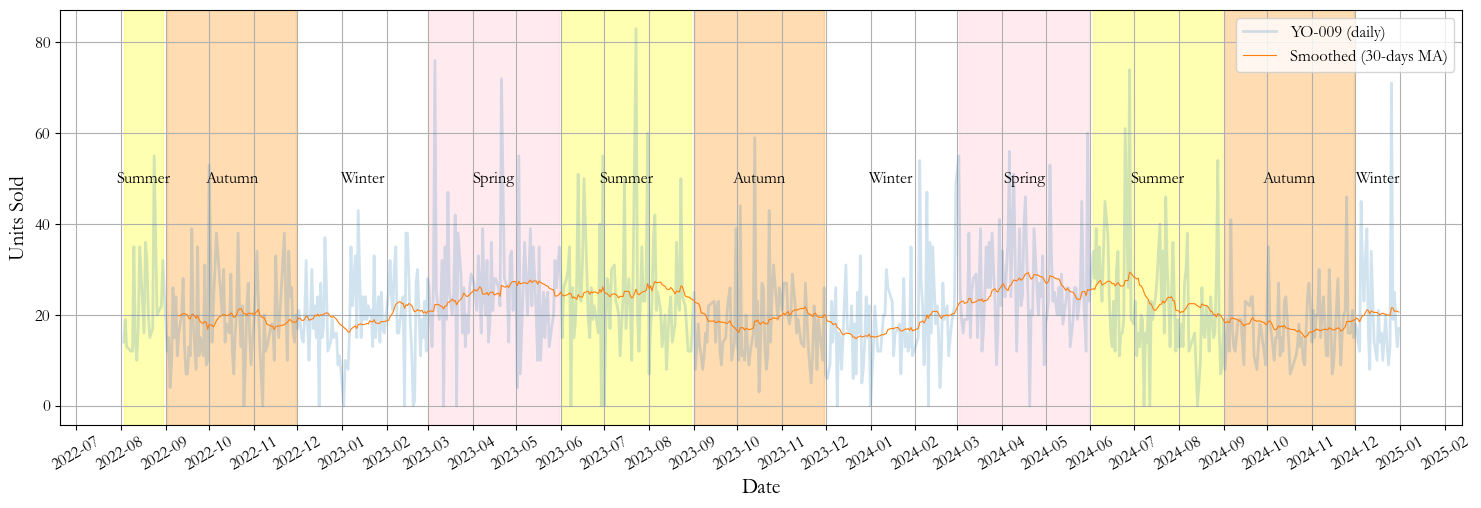

In [41]:
time_series_viz_by_sku("YO-009", True, 30)

## Modelling and Forecasting by SKU

### Grouping Data

In [42]:
target_data = fmcg_dataset.copy()
target_data = target_data.loc[(target_data["sku"] == "YO-009") & (target_data["region"] == "PL-North") & (target_data["channel"] == "Retail")]
target_data = target_data.groupby(by=["date", "season"], as_index=False).agg(units_sold=("units_sold", "sum"),
                                                                       promotion_flag=("promotion_flag", "first"),
                                                                       price_unit=("price_unit", "first"),
                                                                       pack_type=("pack_type", "first"),
                                                                       delivery_days=("delivery_days", "first"),
                                                                       year=("year", "first"),
                                                                       month=("month", "first"),
                                                                       week=("week", "first"),
                                                                       day_of_the_month=("day_of_the_month", "first"),
                                                                       day_of_the_week=("day_of_the_week", "first"),
                                                                       is_weekend=("is_weekend", "first"),
                                                                       is_public_holiday=("is_public_holiday", "first"),
                                                                       sub_season=("sub_season", "first"))


### Filling Missing Dates

In [43]:
date_range = pd.date_range(start=target_data["date"].min(), end=target_data["date"].max(), freq='D')
date_range.difference(target_data["date"])
target_data = pd.concat([target_data, pd.DataFrame(date_range.difference(target_data["date"]), columns=["date"])], ignore_index=True)
target_data.sort_values(by=["date"], inplace=True)
target_data.reset_index(drop=True, inplace=True)

In [44]:
target_data

,date,season,units_sold,promotion_flag,price_unit,pack_type,delivery_days,year,month,week,day_of_the_month,day_of_the_week,is_weekend,is_public_holiday,sub_season
0,2022-08-03,Summer,14.0,0.0,2.82,Multipack,5.0,2022.0,August,31,3.0,Wednesday,False,False,Late-Summer
1,2022-08-04,Summer,19.0,0.0,2.27,Carton,2.0,2022.0,August,31,4.0,Thursday,False,False,Late-Summer
2,2022-08-05,Summer,13.0,0.0,2.77,Single,2.0,2022.0,August,31,5.0,Friday,False,False,Late-Summer
3,2022-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
4,2022-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,2024-12-27,Winter,19.0,0.0,5.26,Single,5.0,2024.0,December,52,27.0,Friday,False,False,Early-Winter
878,2024-12-28,Winter,25.0,0.0,2.47,Single,1.0,2024.0,December,52,28.0,Saturday,True,False,Early-Winter
879,2024-12-29,Winter,18.0,0.0,5.83,Multipack,3.0,2024.0,December,52,29.0,Sunday,True,False,Early-Winter
880,2024-12-30,Winter,13.0,0.0,3.73,Carton,4.0,2024.0,December,1,30.0,Monday,False,False,Early-Winter


### Reapply Previous Functions for Feature Engineering

In [45]:
target_data = chunking_date(target_data)
target_data = categorize_weekend(target_data)
target_data = season_month_mapping(target_data)
target_data["is_public_holiday"] = target_data[["month", "day_of_the_month"]].apply(map_public_holiday, axis=1, args=(public_holidays_list,))
target_data["units_sold"] = target_data["units_sold"].fillna(0)
target_data["units_sold"] = target_data["units_sold"].astype(int)

### Defining the Value of Promotion Flag

This is a hard part because even though I can safely assume **missing dates mean there is no transaction** and **no transaction means no promotion**, still there is a possibility that the promotion was actually active but no sales. 

Therefore, I have no solid proof to tell whether **the promotion was actually active but no sales** or **no promotion in the first place**.

But I'm going to try to calculate the probability of promotion_flag == 0 or 1 based on the day of the week.

In [46]:
promotion_data = target_data[["date", "day_of_the_week"]].loc[target_data["promotion_flag"] == 1].groupby(by=["day_of_the_week"], as_index=False).count()
total_promotion_days = promotion_data["date"].sum()

promotion_data["probability"] = promotion_data["date"].apply(lambda x: x / total_promotion_days * 100).round(2)
promotion_data

,day_of_the_week,date,probability
0,Friday,21,17.65
1,Monday,16,13.45
2,Saturday,18,15.13
3,Sunday,11,9.24
4,Thursday,17,14.29
5,Tuesday,22,18.49
6,Wednesday,14,11.76


In [47]:
non_promotion_data = target_data[["date", "day_of_the_week"]].loc[target_data["promotion_flag"] == 0].groupby(by=["day_of_the_week"], as_index=False).count()
total_non_promotion_days = non_promotion_data["date"].sum()

non_promotion_data["probability"] = non_promotion_data["date"].apply(lambda x: x / total_non_promotion_days * 100).round(2)
non_promotion_data

,day_of_the_week,date,probability
0,Friday,81,12.88
1,Monday,94,14.94
2,Saturday,93,14.79
3,Sunday,91,14.47
4,Thursday,91,14.47
5,Tuesday,88,13.99
6,Wednesday,91,14.47


In [48]:
total_of_all_days = total_promotion_days + total_non_promotion_days
total_of_all_days

np.int64(748)

In [49]:
non_promotion_data["probability_non_promotion_given_day"] = non_promotion_data["date"].apply(lambda x: x / total_of_all_days * 100).round(2)
non_promotion_data.rename(columns={"date":"days", "day_of_the_week":"day_of_the_week_with_no_promotion"}).drop(columns=["probability"], axis=1)

,day_of_the_week_with_no_promotion,days,probability_non_promotion_given_day
0,Friday,81,10.83
1,Monday,94,12.57
2,Saturday,93,12.43
3,Sunday,91,12.17
4,Thursday,91,12.17
5,Tuesday,88,11.76
6,Wednesday,91,12.17


In [50]:
promotion_data["probability_promotion_given_day"] = promotion_data["date"].apply(lambda x: x / total_of_all_days * 100).round(2)
promotion_data.rename(columns={"date":"days", "day_of_the_week":"day_of_the_week_with_promotion"}).drop(columns=["probability"], axis=1)

,day_of_the_week_with_promotion,days,probability_promotion_given_day
0,Friday,21,2.81
1,Monday,16,2.14
2,Saturday,18,2.41
3,Sunday,11,1.47
4,Thursday,17,2.27
5,Tuesday,22,2.94
6,Wednesday,14,1.87


The probability of **promotion_flag == 0** is likely to happen relative to **promotion_flag == 1**.
Therefore, I'm going to **set all NaN values in promotion_flag to 0**

In [51]:
target_data["promotion_flag"] = target_data["promotion_flag"].fillna(0).astype(int)

### Defining the Value of Pack Type

Since there is no way I can tell what kind of pack type on that day that has no sales. I think it will ruin the data if I try to assume based on nothing, and will be safe to just drop the column. 

In [52]:
target_data.drop(["pack_type"], axis=1, inplace=True)

### Defining the Value of Price Unit

Originally, I was going to also add the pack type as the parameter for the calculation. Since I already dropped the pack_type column, I will just use the median price_unit grouped by year and month.

In [53]:
target_data["price_unit"] = target_data["price_unit"].fillna(target_data.groupby(["year", "month"])["price_unit"].transform("median")).round(2)

### Defining the Value of Delivery Days

The same also goes with delivery_days. Since I already dropped the pack_type column, I will just use the median delivery_days grouped by year and month.

In [54]:
target_data["delivery_days"] = target_data["delivery_days"].fillna(target_data.groupby(["year", "month"])["delivery_days"].transform("median")).round(2)

In [55]:
target_data.sort_values(by=["date"], inplace=True)
target_data.reset_index(drop=True, inplace=True)
target_data

,date,season,units_sold,promotion_flag,price_unit,delivery_days,year,month,week,day_of_the_month,day_of_the_week,is_weekend,is_public_holiday,sub_season
0,2022-08-03,Summer,14,0,2.82,5.0,2022,August,31,3,Wednesday,False,False,Late-Summer
1,2022-08-04,Summer,19,0,2.27,2.0,2022,August,31,4,Thursday,False,False,Late-Summer
2,2022-08-05,Summer,13,0,2.77,2.0,2022,August,31,5,Friday,False,False,Late-Summer
3,2022-08-06,Summer,0,0,5.77,3.0,2022,August,31,6,Saturday,False,False,Late-Summer
4,2022-08-07,Summer,0,0,5.77,3.0,2022,August,31,7,Sunday,False,False,Late-Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,2024-12-27,Winter,19,0,5.26,5.0,2024,December,52,27,Friday,True,False,Early-Winter
878,2024-12-28,Winter,25,0,2.47,1.0,2024,December,52,28,Saturday,True,False,Early-Winter
879,2024-12-29,Winter,18,0,5.83,3.0,2024,December,52,29,Sunday,True,False,Early-Winter
880,2024-12-30,Winter,13,0,3.73,4.0,2024,December,1,30,Monday,True,False,Early-Winter


### Adding Several Features

In [56]:
target_data.sort_values(by=["date"], inplace=True)
target_data.reset_index(drop=True, inplace=True)
target_data["lag_7"] = target_data["units_sold"].shift(7).fillna(0)
target_data["lag_7"] = target_data["lag_7"].astype(int)
target_data["moving_average_7"] = target_data["units_sold"].rolling(window=7).mean().fillna(0).round(2)

In [57]:
target_data.head(20)

,date,season,units_sold,promotion_flag,price_unit,delivery_days,year,month,week,day_of_the_month,day_of_the_week,is_weekend,is_public_holiday,sub_season,lag_7,moving_average_7
0,2022-08-03,Summer,14,0,2.82,5.0,2022,August,31,3,Wednesday,False,False,Late-Summer,0,0.00
1,2022-08-04,Summer,19,0,2.27,2.0,2022,August,31,4,Thursday,False,False,Late-Summer,0,0.00
2,2022-08-05,Summer,13,0,2.77,2.0,2022,August,31,5,Friday,False,False,Late-Summer,0,0.00
3,2022-08-06,Summer,0,0,5.77,3.0,2022,August,31,6,Saturday,False,False,Late-Summer,0,0.00
4,2022-08-07,Summer,0,0,5.77,3.0,2022,August,31,7,Sunday,False,False,Late-Summer,0,0.00
5,2022-08-08,Summer,12,0,6.66,3.0,2022,August,32,8,Monday,False,False,Late-Summer,0,0.00
6,2022-08-09,Summer,12,0,3.67,2.0,2022,August,32,9,Tuesday,False,False,Late-Summer,0,10.00
7,2022-08-10,Summer,35,1,8.21,1.0,2022,August,32,10,Wednesday,False,False,Late-Summer,14,13.00
8,2022-08-11,Summer,14,0,5.87,3.0,2022,August,32,11,Thursday,True,False,Late-Summer,19,12.29
9,2022-08-12,Summer,10,0,7.49,4.0,2022,August,32,12,Friday,True,False,Late-Summer,13,11.86


### Naive Forecast

In [58]:
naive_data = target_data.copy()
naive_data_train = naive_data[naive_data["date"] < "2024-06-01"].copy()
naive_data_test = naive_data[naive_data["date"] >= "2024-06-01"].copy()

In [59]:
naive_data_test["naive_prediction"] = naive_data_test["units_sold"].shift(1).fillna(naive_data_train["units_sold"].iloc[-1]).astype(int)
naive_data_test["naive_prediction_error"] = naive_data_test["units_sold"] - naive_data_test["naive_prediction"]
naive_data_test["naive_prediction_absolute_error"] = naive_data_test["naive_prediction_error"].abs()
mae = naive_data_test['naive_prediction_absolute_error'].mean().round(2)
mae

np.float64(12.06)

### Season-Block Naive Forecast

In [60]:
sb_naive_data = target_data.copy()
sb_naive_data_train = sb_naive_data[sb_naive_data["date"] < "2024-06-01"].copy()
sb_naive_data_test = sb_naive_data[sb_naive_data["date"] >= "2024-06-01"].copy()

In [61]:
sb_naive_data_test["sb_naive_prediction"] = sb_naive_data_train[(sb_naive_data_train["date"] >= "2023-06-01") & (sb_naive_data_train["date"] <= "2023-12-31")]["units_sold"].values

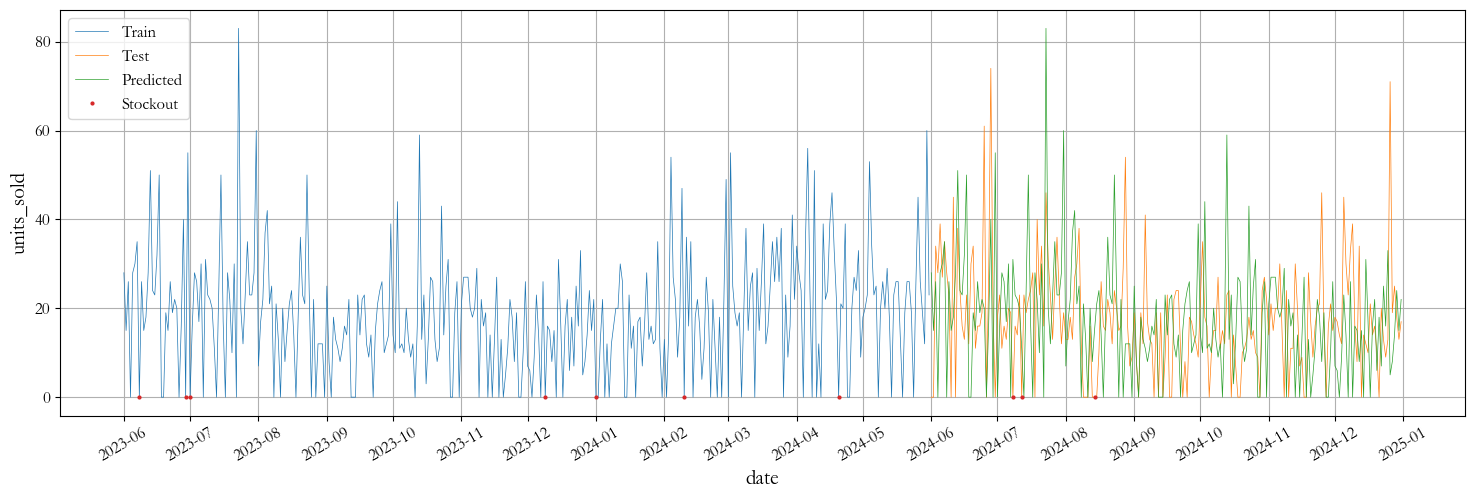

In [62]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sb_naive_data_train.loc[sb_naive_data_train["date"] >= "2023-06-01"]["date"], sb_naive_data_train.loc[sb_naive_data_train["date"] >= "2023-06-01"]["units_sold"], linewidth=0.5, label="Train")
ax.plot(sb_naive_data_test["date"], sb_naive_data_test["units_sold"], linewidth=0.5, label="Test")
ax.plot(sb_naive_data_test["date"], sb_naive_data_test["sb_naive_prediction"], linewidth=0.5, label="Predicted")
ax.plot(fmcg_dataset.loc[(fmcg_dataset["date"] >= "2023-06-01") & (fmcg_dataset["region"] == "PL-North") & (fmcg_dataset["sku"] == "YO-009") &  (fmcg_dataset["channel"] == "Retail") & (fmcg_dataset["stock_available"] == 0)]["date"], 
        fmcg_dataset.loc[(fmcg_dataset["date"] >= "2023-06-01") & (fmcg_dataset["region"] == "PL-North") & (fmcg_dataset["sku"] == "YO-009") &  (fmcg_dataset["channel"] == "Retail") & (fmcg_dataset["stock_available"] == 0)]["units_sold"], ".", markersize=4.0, label="Stockout")

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.set_xlabel("date", fontname="garamond", fontsize=15)
ax.set_ylabel("units_sold", fontname="garamond", fontsize=15)
ax.legend()
ax.grid()
plt.rcParams['font.family'] = 'garamond'
plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

#### MASE

In [63]:
sb_naive_data_test = sb_naive_data_test[["units_sold", "sb_naive_prediction"]].copy()
sb_naive_data_test["sb_error"] = sb_naive_data_test["units_sold"] - sb_naive_data_test["sb_naive_prediction"]
sb_naive_data_test["sb_absolute_error"] = sb_naive_data_test["sb_error"].abs()
sb_naive_data_test["sb_absolute_error/mae"] = sb_naive_data_test["sb_absolute_error"]/mae
sb_naive_data_test

,units_sold,sb_naive_prediction,sb_error,sb_absolute_error,sb_absolute_error/mae
668,0,28,-28,28,2.321725
669,0,15,-15,15,1.243781
670,34,26,8,8,0.663350
671,28,0,28,28,2.321725
672,39,28,11,11,0.912106
...,...,...,...,...,...
877,19,8,11,11,0.912106
878,25,14,11,11,0.912106
879,18,24,-6,6,0.497512
880,13,15,-2,2,0.165837


In [64]:
print(f"MASE: {sb_naive_data_test['sb_absolute_error/mae'].sum()/len(sb_naive_data_test):.2f}")

MASE: 1.08


### SARIMA

In [80]:
sarima_data = target_data.copy()

In [81]:
sarima_data_train = sarima_data[sarima_data["date"] < "2024-06-01"].copy()
sarima_data_test = sarima_data[sarima_data["date"] >= "2024-06-01"].copy()

In [82]:
adfuller_train_result = adfuller(sarima_data_train["units_sold"], autolag="AIC")
print(f"p-value: {adfuller_train_result[1]}")

p-value: 2.607129060838217e-08


p-value < 0.05 means the data is stationary.

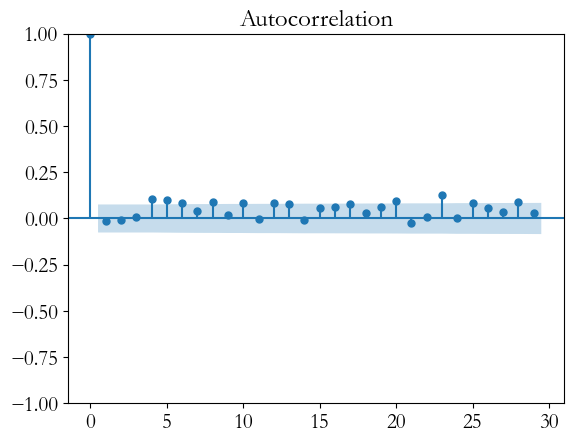

In [84]:
plot_acf(sarima_data_train["units_sold"])
plt.show()

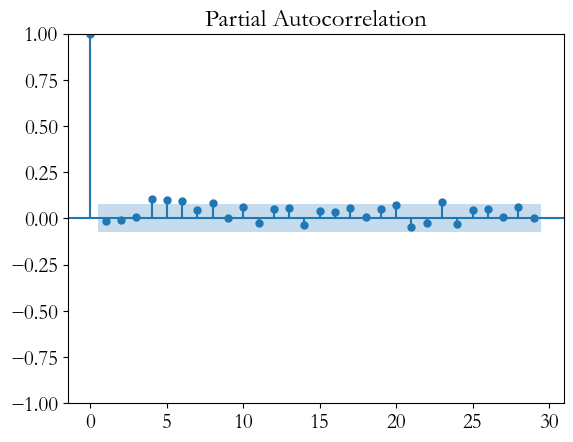

In [85]:
plot_pacf(sarima_data_train["units_sold"])
plt.show()

In [88]:
sarima_regressor = SARIMAX(sarima_data_train["units_sold"], order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
sarima_data_test["prediction"] = sarima_regressor.fit().forecast(steps=214).round(2)
sarima_data_test

,date,season,units_sold,promotion_flag,price_unit,delivery_days,year,month,week,day_of_the_month,day_of_the_week,is_weekend,is_public_holiday,sub_season,lag_7,moving_average_7,prediction
668,2024-06-01,Summer,0,0,5.57,3.0,2024,June,22,1,Saturday,False,False,Early-Summer,25,26.43,19.70
669,2024-06-02,Summer,0,0,5.57,3.0,2024,June,22,2,Sunday,False,False,Early-Summer,45,20.00,22.50
670,2024-06-03,Summer,34,0,2.24,2.0,2024,June,23,3,Monday,False,False,Early-Summer,26,21.14,22.65
671,2024-06-04,Summer,28,0,4.16,3.0,2024,June,23,4,Tuesday,False,False,Early-Summer,19,22.43,25.29
672,2024-06-05,Summer,39,0,5.59,1.0,2024,June,23,5,Wednesday,False,False,Early-Summer,12,26.29,17.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,2024-12-27,Winter,19,0,5.26,5.0,2024,December,52,27,Friday,True,False,Early-Winter,10,20.71,17.77
878,2024-12-28,Winter,25,0,2.47,1.0,2024,December,52,28,Saturday,True,False,Early-Winter,0,24.29,18.00
879,2024-12-29,Winter,18,0,5.83,3.0,2024,December,52,29,Sunday,True,False,Early-Winter,20,24.00,20.87
880,2024-12-30,Winter,13,0,3.73,4.0,2024,December,1,30,Monday,True,False,Early-Winter,13,24.00,19.57


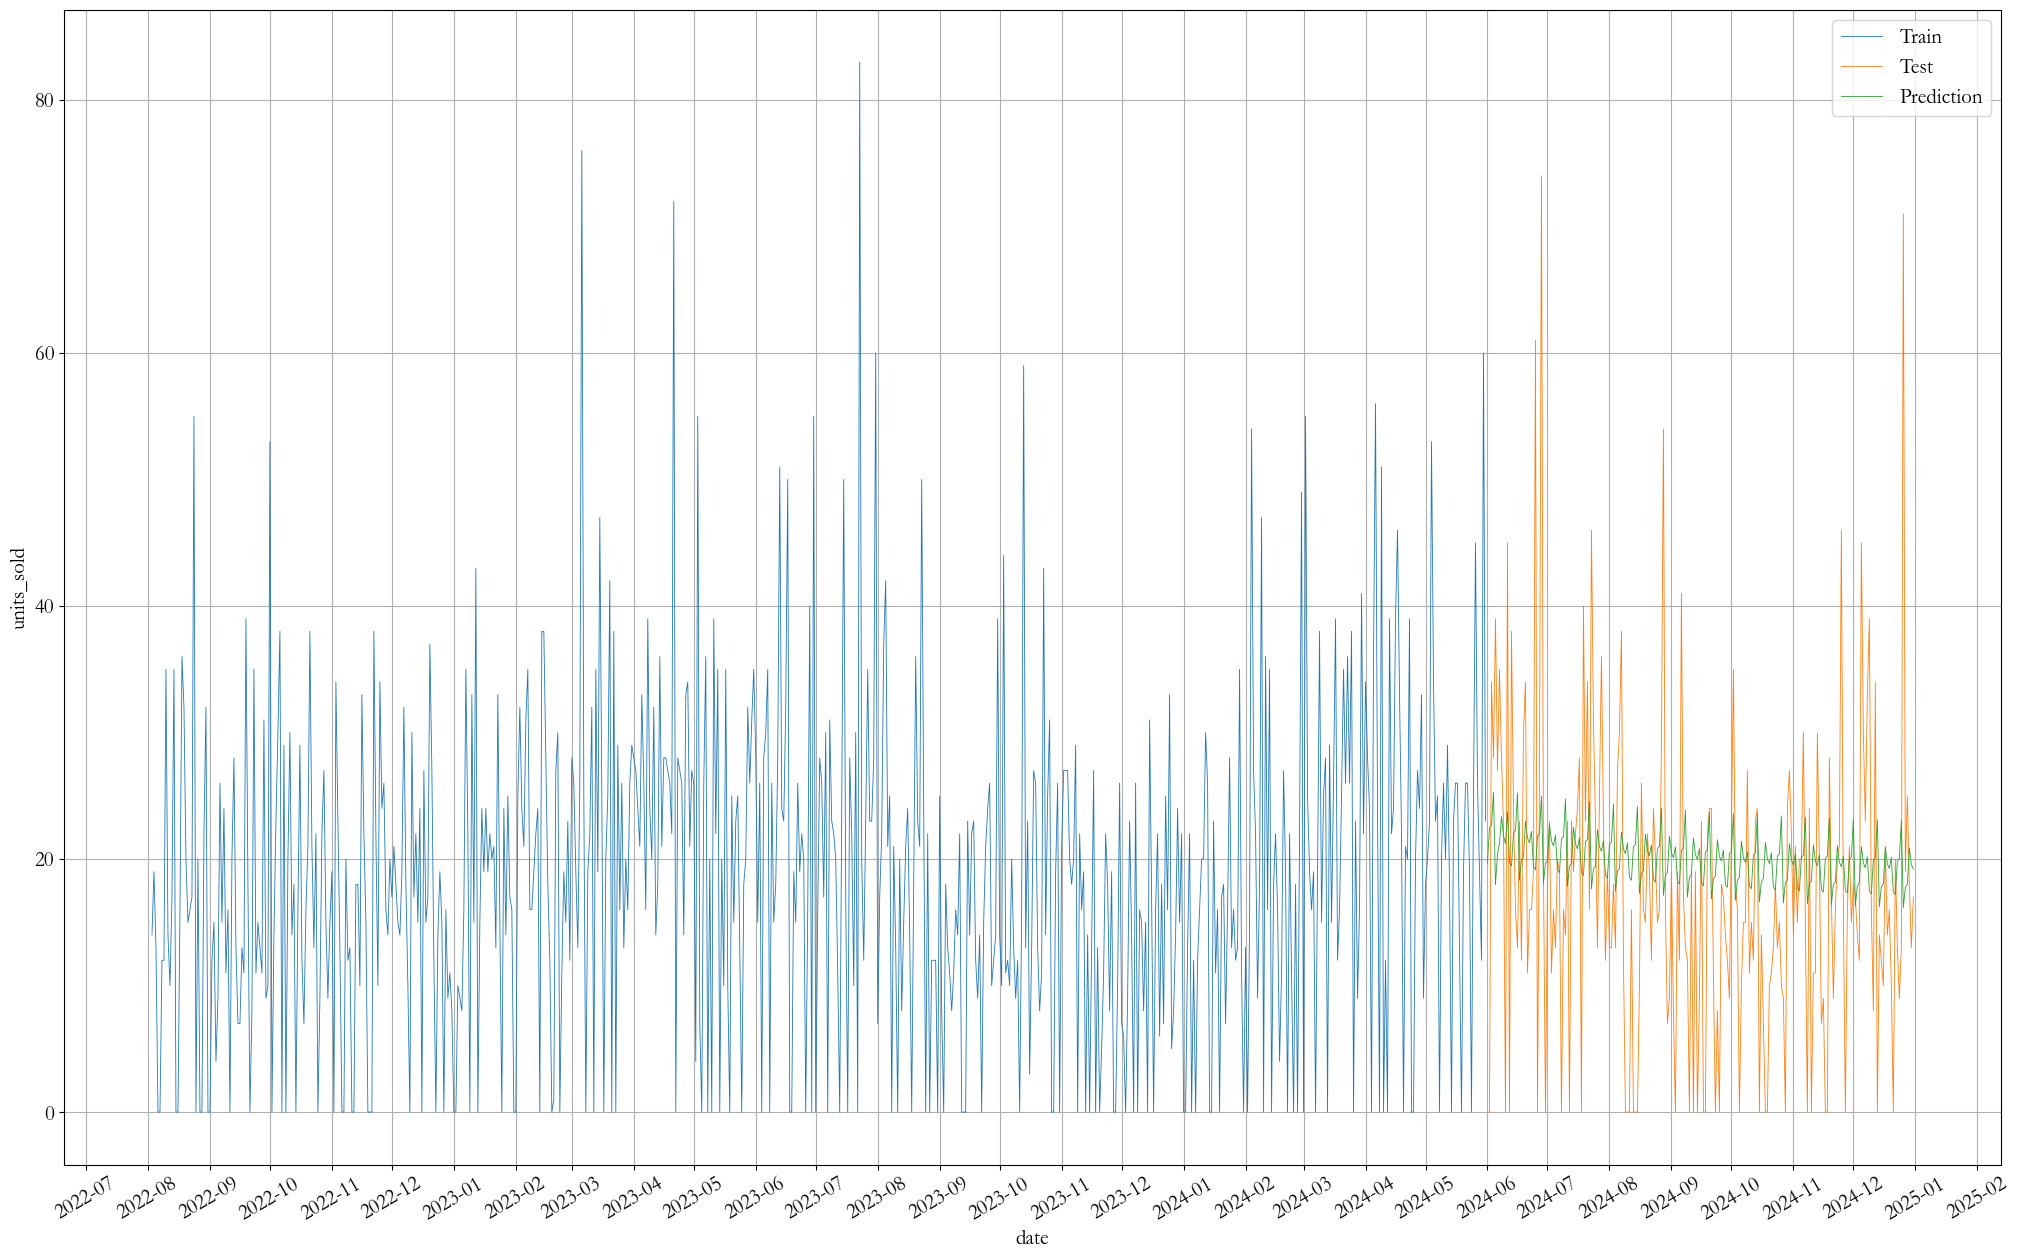

In [89]:
fig, ax = plt.subplots(figsize=(25, 15))

ax.plot(sarima_data_train["date"], sarima_data_train["units_sold"], linewidth=.6, label="Train")
ax.plot(sarima_data_test["date"], sarima_data_test["units_sold"], linewidth=.6, label="Test")
ax.plot(sarima_data_test["date"], sarima_data_test["prediction"], linewidth=.6, label="Prediction")
ax.set_xlabel("date")
ax.set_ylabel("units_sold")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.legend()
ax.grid(True)
plt.xticks(rotation=30)
plt.show()

#### MASE

In [90]:
sarima_data_test = sarima_data_test[["units_sold", "prediction"]].copy()
sarima_data_test["error"] = sarima_data_test["units_sold"] - sarima_data_test["prediction"]
sarima_data_test["absolute_error"] = sarima_data_test["error"].abs()
sarima_data_test["absolute_error/mae"] = sarima_data_test["absolute_error"]/mae
sarima_data_test

,units_sold,prediction,error,absolute_error,absolute_error/mae
668,0,19.70,-19.70,19.70,1.633499
669,0,22.50,-22.50,22.50,1.865672
670,34,22.65,11.35,11.35,0.941128
671,28,25.29,2.71,2.71,0.224710
672,39,17.98,21.02,21.02,1.742952
...,...,...,...,...,...
877,19,17.77,1.23,1.23,0.101990
878,25,18.00,7.00,7.00,0.580431
879,18,20.87,-2.87,2.87,0.237977
880,13,19.57,-6.57,6.57,0.544776


In [91]:
print(f"MASE: {sarima_data_test['absolute_error/mae'].sum()/len(sarima_data_test):.2f}")

MASE: 0.79


### SARIMAX

In [ ]:
sarimax_data = target_data.copy()

### XGBoost

In [92]:
xgboost_data = target_data.copy()

#### Changing Type of Several Columns

In [93]:
xgboost_data["month"] = xgboost_data["month"].astype("category")
xgboost_data["day_of_the_week"] = xgboost_data["day_of_the_week"].astype("category")
xgboost_data["season"] = xgboost_data["season"].astype("category")
xgboost_data["sub_season"] = xgboost_data["sub_season"].astype("category")
xgboost_data.reset_index(drop=True, inplace=True)

#### Train-Test Data Split

In [94]:
xgboost_data_train = xgboost_data[xgboost_data["date"] < "2024-06-01"].copy()
xgboost_data_test = xgboost_data[xgboost_data["date"] >= "2024-06-01"].copy()

#### Train

In [95]:
FEATURES = ["month", "week", "day_of_the_month", "day_of_the_week", "season", "sub_season", "is_weekend", 
            "is_public_holiday", "price_unit", "promotion_flag", "delivery_days", "lag_7", "moving_average_7"]

TARGET = "units_sold"

X_train = xgboost_data_train[FEATURES]
y_train = xgboost_data_train[TARGET]

X_test = xgboost_data_test[FEATURES]
y_test = xgboost_data_test[TARGET]

In [96]:
regressor = xgb.XGBRegressor(base_score=.5, booster="gbtree", 
                             n_estimators=1000, early_stopping_rounds=100,
                             objective="reg:squarederror", max_depth=100, 
                             learning_rate=0.01, enable_categorical=True)

regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:22.00321	validation_1-rmse:20.76905
[100]	validation_0-rmse:9.73227	validation_1-rmse:12.00610
[200]	validation_0-rmse:4.58783	validation_1-rmse:10.14716
[300]	validation_0-rmse:2.23533	validation_1-rmse:9.69943
[400]	validation_0-rmse:1.13837	validation_1-rmse:9.64463
[487]	validation_0-rmse:0.66267	validation_1-rmse:9.69423


,objective,'reg:squarederror'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,100
,enable_categorical,True
,eval_metric,None


#### Feature Importance

<Axes: title={'center': 'Feature Importance'}>

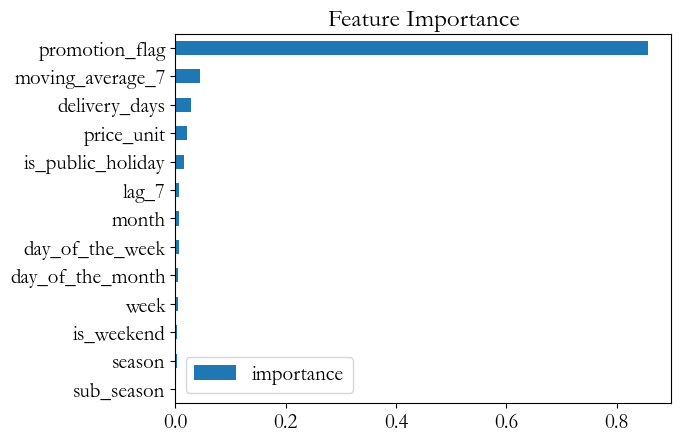

In [97]:
feature_importance = pd.DataFrame(data=regressor.feature_importances_, 
                                  index=regressor.feature_names_in_, 
                                  columns=["importance"])

feature_importance.sort_values("importance").plot(kind="barh", title="Feature Importance")

#### Test

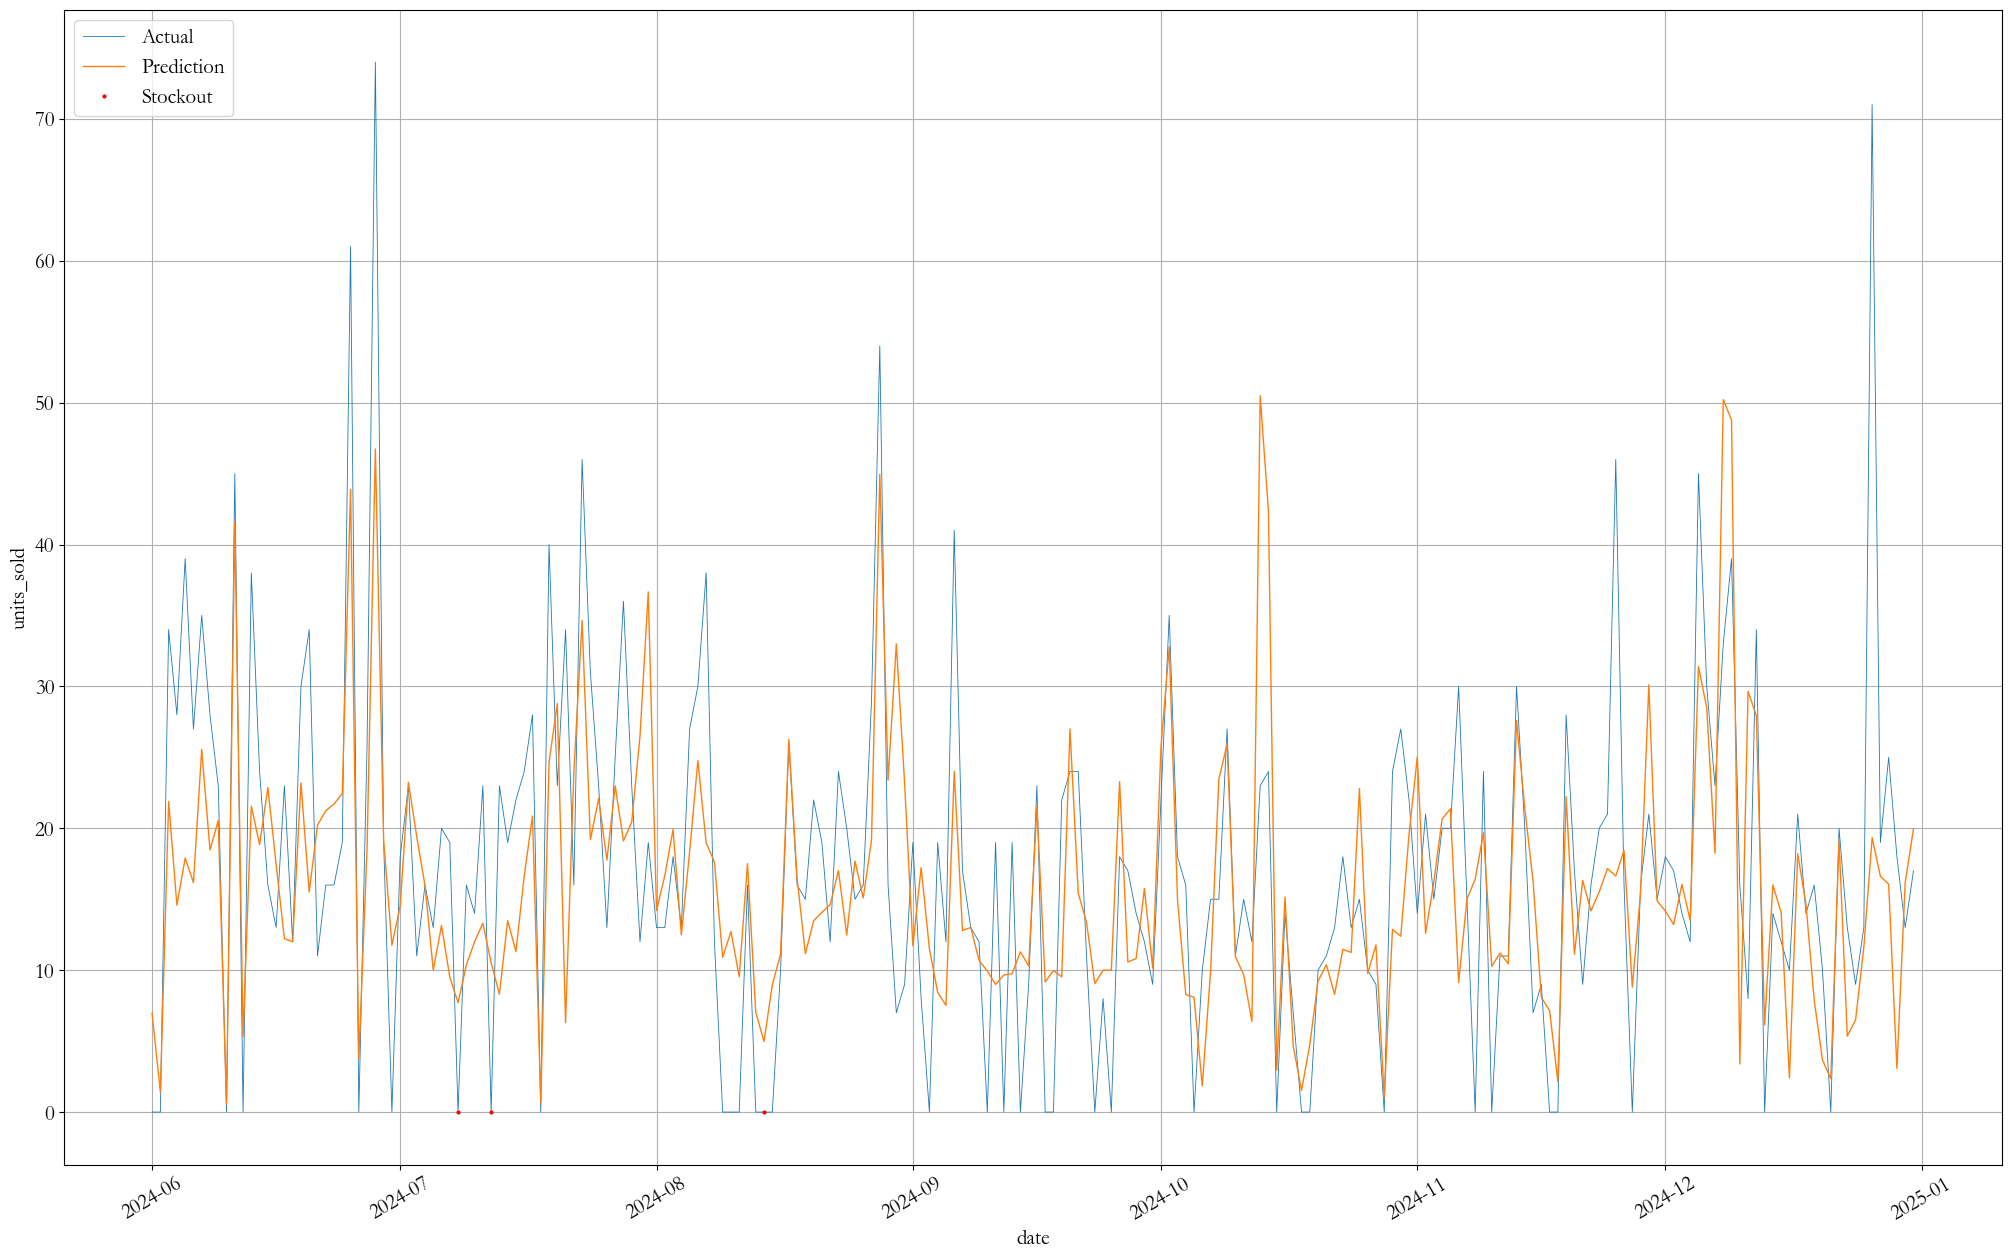

In [98]:
xgboost_data_test["prediction"] = regressor.predict(X_test)
xgboost_data_test["prediction"] = xgboost_data_test["prediction"].round(2)
fig, ax = plt.subplots(figsize=(25, 15))

ax.plot(xgboost_data_test["date"], xgboost_data_test["units_sold"], linewidth=.6, label="Actual")
ax.plot(xgboost_data_test["date"], xgboost_data_test["prediction"], linewidth=1.0, label="Prediction")
ax.plot(fmcg_dataset.loc[(fmcg_dataset["date"] >= "2024-06-01") & (fmcg_dataset["region"] == "PL-North") & (fmcg_dataset["sku"] == "YO-009") &  (fmcg_dataset["channel"] == "Retail") & (fmcg_dataset["stock_available"] == 0)]["date"], 
        fmcg_dataset.loc[(fmcg_dataset["date"] >= "2024-06-01") & (fmcg_dataset["region"] == "PL-North") & (fmcg_dataset["sku"] == "YO-009") &  (fmcg_dataset["channel"] == "Retail") & (fmcg_dataset["stock_available"] == 0)]["units_sold"], "r.", markersize=4.0, label="Stockout")
ax.set_xlabel("date")
ax.set_ylabel("units_sold")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.legend()
ax.grid(True)
plt.xticks(rotation=30)
plt.show()

#### MASE

In [99]:
xgboost_data_test = xgboost_data_test[["units_sold", "prediction"]].copy()
xgboost_data_test["error"] = xgboost_data_test["units_sold"] - xgboost_data_test["prediction"]
xgboost_data_test["absolute_error"] = xgboost_data_test["error"].abs()
xgboost_data_test["absolute_error/mae"] = xgboost_data_test["absolute_error"]/mae

xgboost_data_test

,units_sold,prediction,error,absolute_error,absolute_error/mae
668,0,6.960000,-6.960000,6.960000,0.577114
669,0,1.420000,-1.420000,1.420000,0.117745
670,34,21.889999,12.110001,12.110001,1.004146
671,28,14.580000,13.420000,13.420000,1.112769
672,39,17.900000,21.100000,21.100000,1.749585
...,...,...,...,...,...
877,19,16.620001,2.379999,2.379999,0.197347
878,25,16.059999,8.940001,8.940001,0.741294
879,18,3.080000,14.920000,14.920000,1.237148
880,13,16.190001,-3.190001,3.190001,0.264511


In [100]:
print(f"MASE: {xgboost_data_test['absolute_error/mae'].sum()/len(xgboost_data_test):.2f}")

MASE: 0.58
